In [ ]:
#@title Install
!pip install fairlearn
!pip install -upgrade scikit-learn
!pip install shap
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 4.1 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha

In [ ]:
#@title Imports
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio,
                               selection_rate_difference, false_negative_rate_difference,
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

import shap

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
%matplotlib inline

import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Content below includes some data validation by the original creator and some by us

In [ ]:
#@title Reading data { display-mode: "form" }
train = pd.read_csv('/content/drive/My Drive/final_data/application_train.csv')
print("train data: %s rows and %s cols"%train.shape)
test = pd.read_csv('/content/drive/My Drive/final_data/application_test.csv')
print("test data: %s rows and %s cols"%test.shape)
cc = pd.read_csv('/content/drive/My Drive/final_data/credit_card_balance.csv')
print("Credit Card Balance: %s rows and %s cols"%cc.shape)
pmts = pd.read_csv('/content/drive/My Drive/final_data/installments_payments.csv')
print("Installments Payments: %s rows and %s cols"%pmts.shape)

train data: 307511 rows and 122 cols
test data: 48744 rows and 121 cols
Credit Card Balance: 3840312 rows and 23 cols
Installments Payments: 13605401 rows and 8 cols


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [ ]:
train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [ ]:
train.dtypes

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


In [ ]:
train.isnull().sum()[train.isnull().sum() > 2000]

OWN_CAR_AGE                     202929
OCCUPATION_TYPE                  96391
EXT_SOURCE_1                    173378
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE                 156061
BASEMENTAREA_MODE               179943
YEARS_BEGINEXPLUATATION_MODE    150007
YEARS_BUILD_MODE                204488
COMMONAREA_MODE                 214865
ELEVATORS_MODE                  163891
ENTRANCES_MODE                  154828
FLOORSMAX_MODE           

In [ ]:
cc.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
count              3.090496e+06             3.535076e+06         3.072324e+06   
mean               2.968805e+03             3.540204e+03         1.028054e+04   
std                2.079689e+04             5.600154e+03         3.607808e+04   
min                0.000000e+00             0.000000e+00         0.000000e+00   
25%                0.000000e+00             0.000000e+00         1.523700e+02   
50%                0.000000e+00             0.000000e+00         2.702700e+03   
75%                0.000000e+00             6.633911e+03         9.000000e+03   
max                2.239274e+06             2.028820e+05         4.289207e+06   

       AMT_PAYMENT_TOTAL_CURRENT  AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  \
count               3.840312e+06              3.840312e+06   3.840312e+06   
mean                7.588857e+03              5.596588e+04   5.808881e+04   
std                 3.200599e+04              1.025336e+05   1.059654e+05   
min                 0.000000e+00             -4.233058e+05  -4.202502e+05   
25%                 0.000000e+00              0.000000e+00   0.000000e+00   
50%                 0.000000e+00              0.000000e+00   0.000000e+00   
75%                 6.750000e+03              8.535924e+04   8.889949e+04   
max                 4.278316e+06              1.472317e+06   1.493338e+06   

       AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count          3.840312e+06              3.090496e+06          3.840312e+06   
mean           5.809829e+04              3.094490e-01          7.031439e-01   
std            1.059718e+05              1.100401e+00          3.190347e+00   
min           -4.202502e+05              0.000000e+00          0.000000e+00   
25%            0.000000e+00              0.000000e+00          0.000000e+00   
50%            0.000000e+00              0.000000e+00          0.000000e+00   
75%            8.891451e+04              0.000000e+00          0.000000e+00   
max            1.493338e+06              5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std    

In [ ]:
cc.dtypes

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

In [ ]:
cc.isnull().sum()[cc.isnull().sum() > 0]

AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
dtype: int64

In [ ]:
pmts.describe()

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

In [ ]:
pmts.dtypes

SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

In [ ]:
pmts.isnull().sum()[pmts.isnull().sum() > 0]

DAYS_ENTRY_PAYMENT    2905
AMT_PAYMENT           2905
dtype: int64

In [ ]:
cc.corr('pearson')

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  \
SK_ID_PREV                    1.000000    0.004723        0.003670   
SK_ID_CURR                    0.004723    1.000000        0.001696   
MONTHS_BALANCE                0.003670    0.001696        1.000000   
AMT_BALANCE                   0.005046    0.003510        0.014558   
AMT_CREDIT_LIMIT_ACTUAL       0.006631    0.005991        0.199900   
AMT_DRAWINGS_ATM_CURRENT      0.004342    0.000814        0.036802   
AMT_DRAWINGS_CURRENT          0.002624    0.000708        0.065527   
AMT_DRAWINGS_OTHER_CURRENT   -0.000160    0.000958        0.000405   
AMT_DRAWINGS_POS_CURRENT      0.001721   -0.000786        0.118146   
AMT_INST_MIN_REGULARITY       0.006460    0.003300       -0.087529   
AMT_PAYMENT_CURRENT           0.003472    0.000127        0.076355   
AMT_PAYMENT_TOTAL_CURRENT     0.001641    0.000784        0.035614   
AMT_RECEIVABLE_PRINCIPAL      0.005140    0.003589        0.016266   
AMT_RECIVABLE                 0.005035    0.003518        0.013172   
AMT_TOTAL_RECEIVABLE          0.005032    0.003524        0.013084   
CNT_DRAWINGS_ATM_CURRENT      0.002821    0.002082        0.002536   
CNT_DRAWINGS_CURRENT          0.000367    0.002654        0.113321   
CNT_DRAWINGS_OTHER_CURRENT   -0.001412   -0.000131       -0.026192   
CNT_DRAWINGS_POS_CURRENT      0.000809    0.002135        0.160207   
CNT_INSTALMENT_MATURE_CUM    -0.007219   -0.000581       -0.008620   
SK_DPD                       -0.001786   -0.000962        0.039434   
SK_DPD_DEF                    0.001973    0.001519        0.001659   

                            AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_PREV                     0.005046                 0.006631   
SK_ID_CURR                     0.003510                 0.005991   
MONTHS_BALANCE                 0.014558                 0.199900   
AMT_BALANCE                    1.000000                 0.489386   
AMT_CREDIT_LIMIT_ACTUAL        0.489386                 1.000000   
AMT_DRAWINGS_ATM_CURRENT       0.283551                 0.247219   
AMT_DRAWINGS_CURRENT           0.336965                 0.263093   
AMT_DRAWINGS_OTHER_CURRENT     0.065366                 0.050579   
AMT_DRAWINGS_POS_CURRENT       0.169449                 0.234976   
AMT_INST_MIN_REGULARITY        0.896728                 0.467620   
AMT_PAYMENT_CURRENT            0.143934                 0.308294   
AMT_PAYMENT_TOTAL_CURRENT      0.151349                 0.226570   
AMT_RECEIVABLE_PRINCIPAL       0.999720                 0.490445   
AMT_RECIVABLE                  0.999917                 0.488641   
AMT_TOTAL_RECEIVABLE           0.999897                 0.488598   
CNT_DRAWINGS_ATM_CURRENT       0.309968                 0.221808   
CNT_DRAWINGS_CURRENT           0.259184                 0.204237   
CNT_DRAWINGS_OTHER_CURRENT     0.046563                 0.030051   
CNT_DRAWINGS_POS_CURRENT       0.155553                 0.202868   
CNT_INSTALMENT_MATURE_CUM      0.005009                -0.157269   
SK_DPD                        -0.046988                -0.038791   
SK_DPD_DEF                     0.013009                -0.002236   

                            AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
SK_ID_PREV                                  0.004342              0.002624   
SK_ID_CURR                                  0.000814              0.000708   
MONTHS_BALANCE                              0.036802              0.065527   
AMT_BALANCE                                 0.283551              0.336965   
AMT_CREDIT_LIMIT_ACTUAL                     0.247219              0.263093   
AMT_DRAWINGS_ATM_CURRENT                    1.000000              0.800190   
AMT_DRAWINGS_CURRENT                        0.800190              1.000000   
AMT_DRAWINGS_OTHER_CURRENT                  0.017899              0.236297   
AMT_DRAWINGS_POS_CURRENT                    0.078971              0.615591   
AMT_INST_MIN_REGULARITY                     0.094824              0.1244

In [ ]:
pmts.corr()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
SK_ID_PREV                1.000000    0.002132                0.000685   
SK_ID_CURR                0.002132    1.000000                0.000480   
NUM_INSTALMENT_VERSION    0.000685    0.000480                1.000000   
NUM_INSTALMENT_NUMBER    -0.002095   -0.000548               -0.323414   
DAYS_INSTALMENT           0.003748    0.001191                0.130244   
DAYS_ENTRY_PAYMENT        0.003734    0.001215                0.128124   
AMT_INSTALMENT            0.002042   -0.000226                0.168109   
AMT_PAYMENT               0.001887   -0.000124                0.177176   

                        NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
SK_ID_PREV                          -0.002095         0.003748   
SK_ID_CURR                          -0.000548         0.001191   
NUM_INSTALMENT_VERSION              -0.323414         0.130244   
NUM_INSTALMENT_NUMBER                1.000000         0.090286   
DAYS_INSTALMENT                      0.090286         1.000000   
DAYS_ENTRY_PAYMENT                   0.094305         0.999491   
AMT_INSTALMENT                      -0.089640         0.125985   
AMT_PAYMENT                         -0.087664         0.127018   

                        DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
SK_ID_PREV                        0.003734        0.002042     0.001887  
SK_ID_CURR                        0.001215       -0.000226    -0.000124  
NUM_INSTALMENT_VERSION            0.128124        0.168109     0.177176  
NUM_INSTALMENT_NUMBER             0.094305       -0.089640    -0.087664  
DAYS_INSTALMENT                   0.999491        0.125985     0.127018  
DAYS_ENTRY_PAYMENT                1.000000        0.125555     0.126602  
AMT_INSTALMENT                    0.125555        1.000000     0.937191  
AMT_PAYMENT                       0.126602        0.937191     1.000000

In [ ]:
train.corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


SK_ID_CURR    TARGET  CNT_CHILDREN  \
SK_ID_CURR                      1.000000 -0.002108     -0.001129   
TARGET                         -0.002108  1.000000      0.019187   
CNT_CHILDREN                   -0.001129  0.019187      1.000000   
AMT_INCOME_TOTAL               -0.001820 -0.003982      0.012882   
AMT_CREDIT                     -0.000343 -0.030369      0.002145   
AMT_ANNUITY                    -0.000433 -0.012817      0.021374   
AMT_GOODS_PRICE                -0.000232 -0.039645     -0.001827   
REGION_POPULATION_RELATIVE      0.000849 -0.037227     -0.025573   
DAYS_BIRTH                     -0.001500  0.078239      0.330938   
DAYS_EMPLOYED                   0.001366 -0.044932     -0.239818   
DAYS_REGISTRATION              -0.000973  0.041975      0.183395   
DAYS_ID_PUBLISH                -0.000384  0.051457     -0.028019   
OWN_CAR_AGE                     0.001818  0.037612      0.008494   
FLAG_MOBIL                      0.002804  0.000534      0.001041   
FLAG_EMP_PHONE                 -0.001337  0.045982      0.240714   
FLAG_WORK_PHONE                -0.000415  0.028524      0.055630   
FLAG_CONT_MOBILE                0.002815  0.000370     -0.000794   
FLAG_PHONE                      0.002753 -0.023806     -0.029906   
FLAG_EMAIL                      0.000281 -0.001758      0.022619   
CNT_FAM_MEMBERS                -0.002895  0.009308      0.879161   
REGION_RATING_CLIENT           -0.001075  0.058899      0.025423   
REGION_RATING_CLIENT_W_CITY    -0.001138  0.060893      0.024781   
HOUR_APPR_PROCESS_START         0.000350 -0.024166     -0.007292   
REG_REGION_NOT_LIVE_REGION     -0.000283  0.005576     -0.013319   
REG_REGION_NOT_WORK_REGION      0.001097  0.006942      0.008185   
LIVE_REGION_NOT_WORK_REGION     0.002903  0.002819      0.014835   
REG_CITY_NOT_LIVE_CITY         -0.001885  0.044395      0.020072   
REG_CITY_NOT_WORK_CITY         -0.001582  0.050994      0.070650   
LIVE_CITY_NOT_WORK_CITY         0.000067  0.032518      0.069957   
EXT_SOURCE_1                    0.000082 -0.155317     -0.138470   
EXT_SOURCE_2                    0.002342 -0.160472     -0.018015   
EXT_SOURCE_3                    0.000222 -0.178919     -0.042710   
APARTMENTS_AVG                  0.001556 -0.029498     -0.013222   
BASEMENTAREA_AVG               -0.002070 -0.022746     -0.008464   
YEARS_BEGINEXPLUATATION_AVG     0.001551 -0.009728      0.006902   
YEARS_BUILD_AVG                 0.005900 -0.022149      0.030172   
COMMONAREA_AVG                 -0.001463 -0.018550      0.000140   
ELEVATORS_AVG                   0.004862 -0.034199     -0.007060   
ENTRANCES_AVG                  -0.002879 -0.019172     -0.008341   
FLOORSMAX_AVG                   0.004851 -0.044003     -0.009705   
FLOORSMIN_AVG                   0.003083 -0.033614     -0.008753   
LANDAREA_AVG                    0.001465 -0.010885     -0.003121   
LIVINGAPARTMENTS_AVG            0.003119 -0.025031     -0.008648   
LIVINGAREA_AVG                  0.001770 -0.032997     -0.010116   
NONLIVINGAPARTMENTS_AVG        -0.002575 -0.003176      0.004051   
NONLIVINGAREA_AVG               0.003042 -0.013578      0.000028   
APARTMENTS_MODE                 0.001961 -0.027284     -0.012105   
BASEMENTAREA_MODE              -0.001411 -0.019952     -0.008513   
YEARS_BEGINEXPLUATATION_MODE    0.001890 -0.009036      0.006199   
YEARS_BUILD_MODE                0.005245 -0.022068      0.029549   
COMMONAREA_MODE                -0.001058 -0.016340      0.000440   
ELEVATORS_MODE                  0.005017 -0.032131     -0.006397   
ENTRANCES_MODE                 -0.002844 -0.017387     -0.006880   
FLOORSMAX_MODE                  0.004386 -0.043226     -0.009550   
FLOORSMIN_MODE                  0.002081 -0.032698     -0.008044   
LANDAREA_MODE                   0.001548 -0.010174     -0.002212   
LIVINGAPARTMENTS_MODE           0.003589 -0.023393     -0.007955   
LIVINGAREA_MODE                 0.002156 -0.030685     -0.009517   
NONLIVINGAPARTMENT

<Axes: title={'center': 'target var: default indicator'}, ylabel='Frequency'>

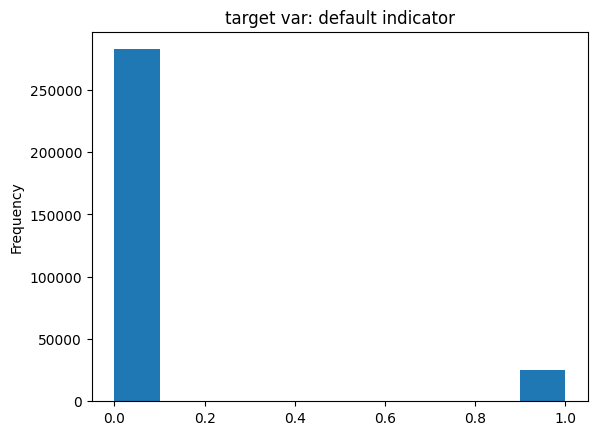

In [ ]:
#@title Data Visualization - Train Data From the density plot we can see class 0 has a lot more records than class 1. Overall the default rate is at 8%. This is an imblanced dataset.
train['TARGET'].plot.hist(title = 'target var: default indicator')

In [ ]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<Axes: title={'center': 'Num of Children'}, ylabel='Frequency'>

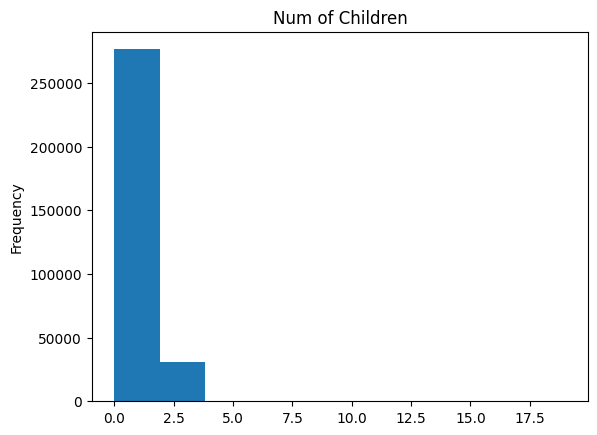

In [ ]:
#@title The mean and 75% percentile of number of children are 0.417052 and 1. There are some outliers we can remove before building the model.
train['CNT_CHILDREN'].plot.hist(title = 'Num of Children')

<Axes: xlabel='CNT_CHILDREN'>

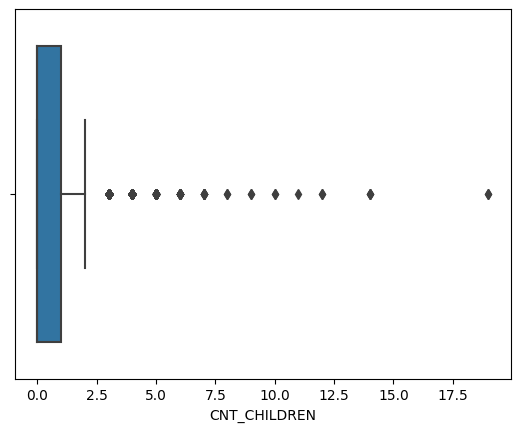

In [ ]:
sns.boxplot(x=train['CNT_CHILDREN'])

<Axes: xlabel='AMT_INCOME_TOTAL'>

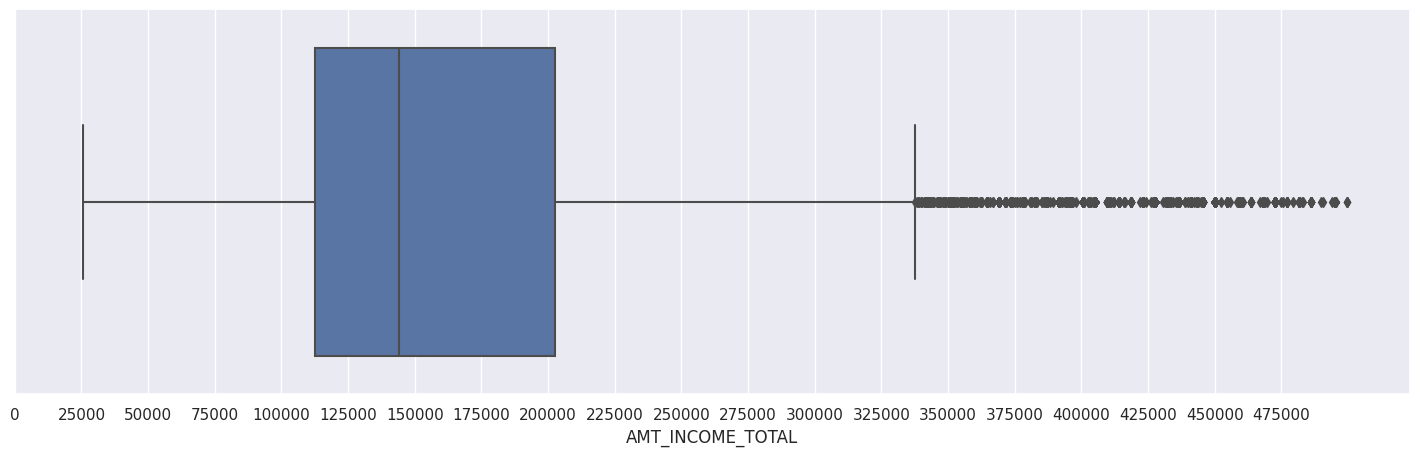

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
ax = sns.boxplot(x=train[train.AMT_INCOME_TOTAL < 0.05e+07]['AMT_INCOME_TOTAL'])
ax.set_xticks(range(0,500000,25000))
ax



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Text(0, 0.5, 'Frequency')

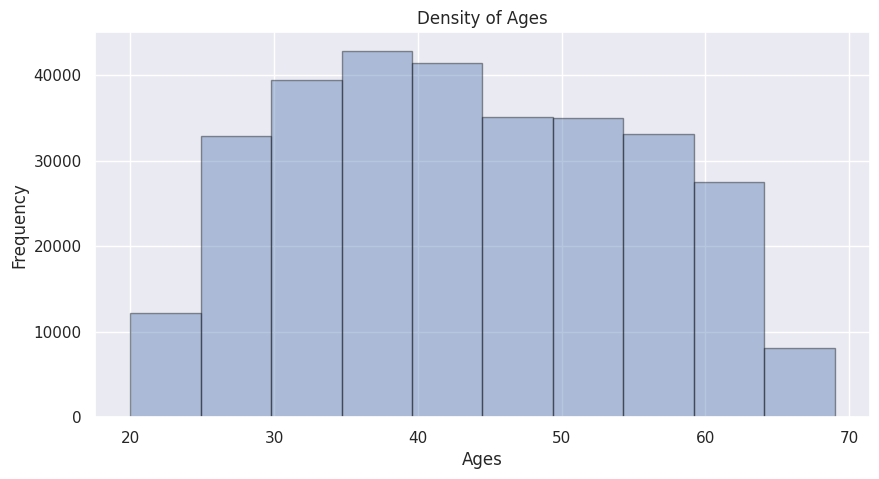

In [ ]:
ages = [int(-x/365) for x in train.DAYS_BIRTH]
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(ages, hist=True, kde=False,
             bins=10,hist_kws={'edgecolor':'black'})
plt.title('Density of Ages')
plt.xlabel('Ages')
plt.ylabel('Frequency')

<Axes: title={'center': 'Non-match Address'}, ylabel='Frequency'>

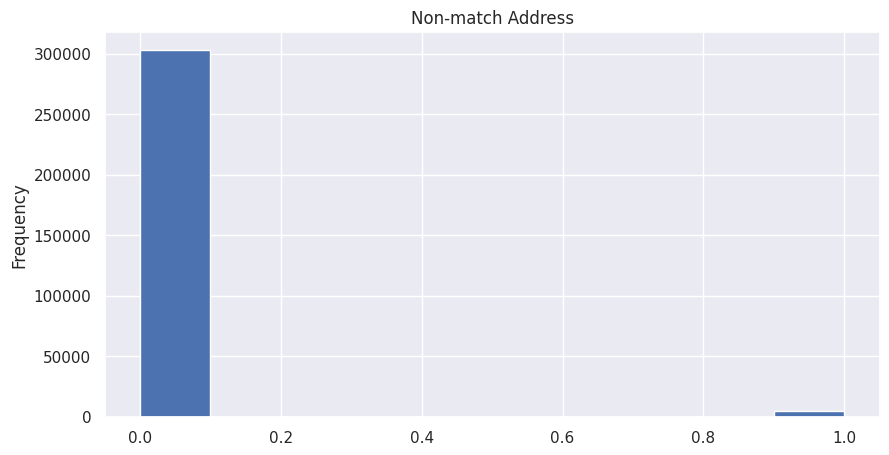

In [ ]:
train['REG_REGION_NOT_LIVE_REGION'].plot.hist(title = 'Non-match Address')

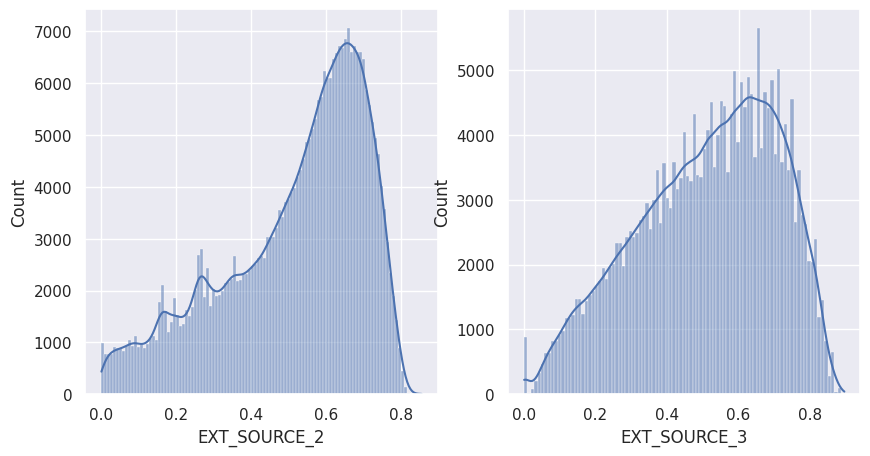

In [ ]:
fig, ax = plt.subplots(1,2)
sns.histplot(data=train, x="EXT_SOURCE_2",kde=True,ax=ax[0])
sns.histplot(data=train, x="EXT_SOURCE_3",kde=True,ax=ax[1])
fig.show()

object column NAME_CONTRACT_TYPE have 2 unique values
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64
-------------
object column CODE_GENDER have 3 unique values
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
-------------
object column FLAG_OWN_CAR have 2 unique values
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
-------------
object column FLAG_OWN_REALTY have 2 unique values
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
-------------
object column NAME_TYPE_SUITE have 7 unique values
object column NAME_INCOME_TYPE have 8 unique values
object column NAME_EDUCATION_TYPE have 5 unique values
object column NAME_FAMILY_STATUS have 6 unique values
object column NAME_HOUSING_TYPE have 6 unique values
object column OCCUPATION_TYPE have 18 unique values
object column WEEKDAY_APPR_PROCESS_START have 7 unique values
object column ORGANIZATION_TYPE have 58 unique values
object column FONDKAPREMONT_M

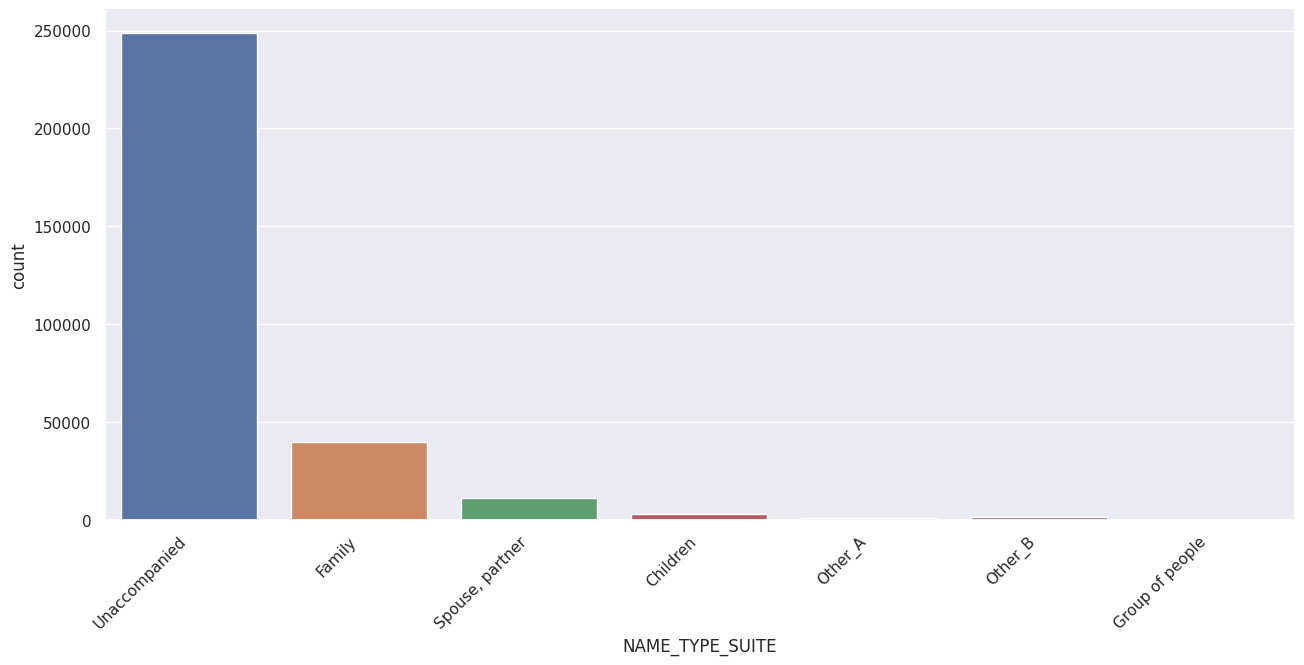

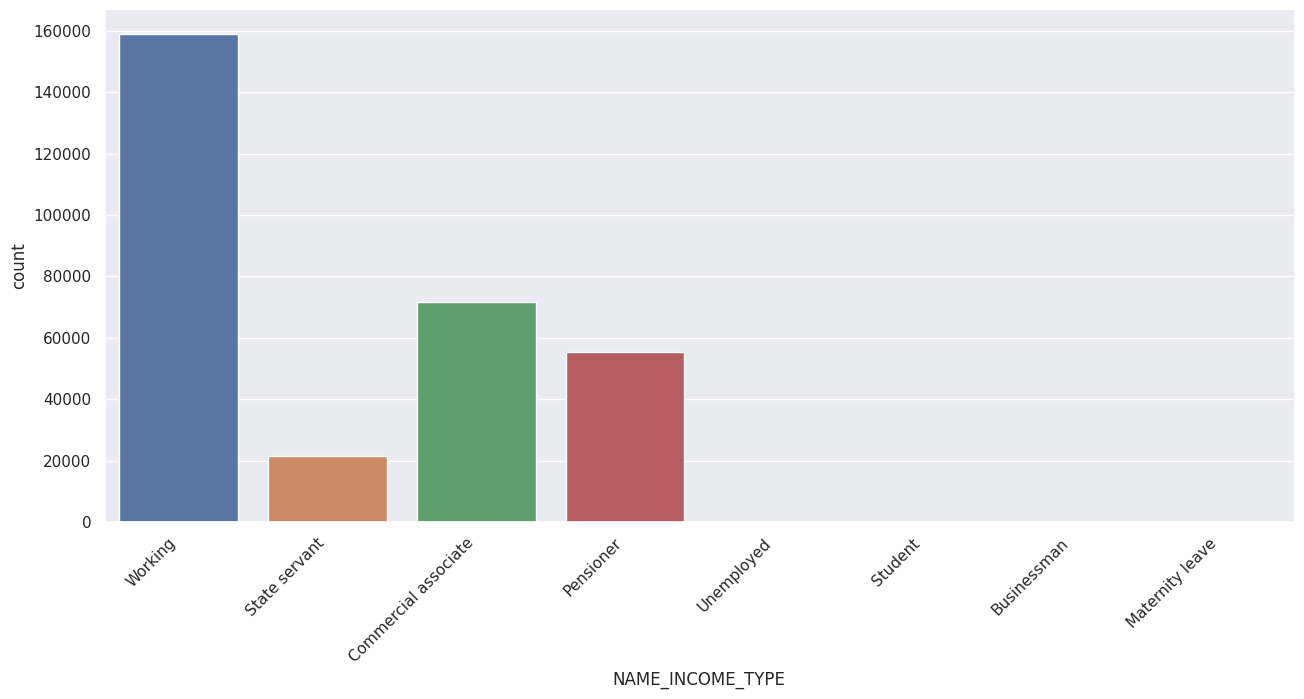

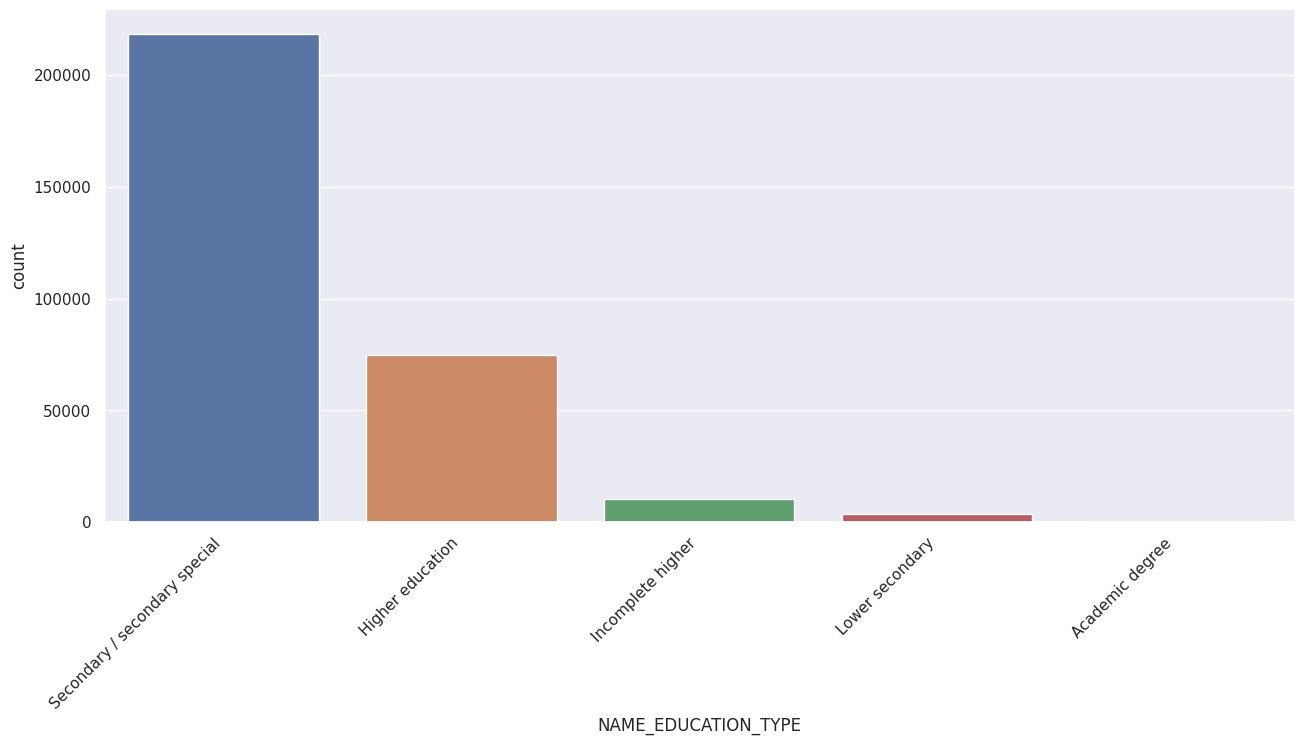

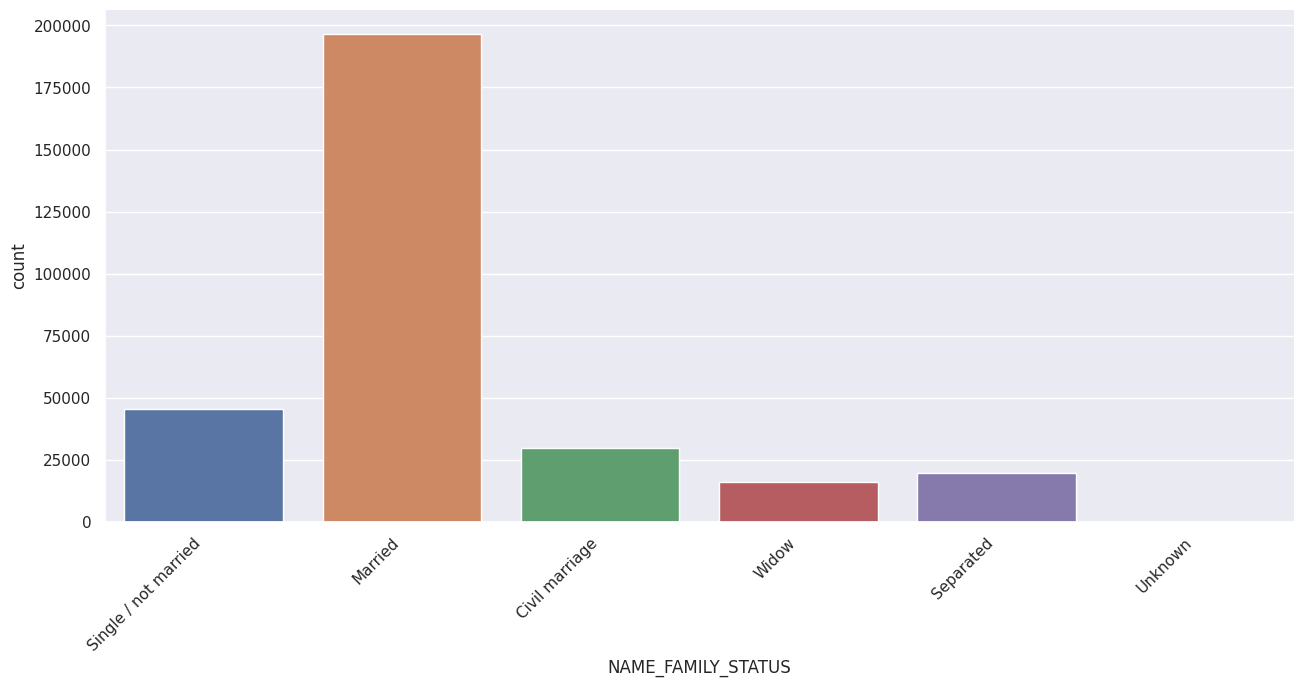

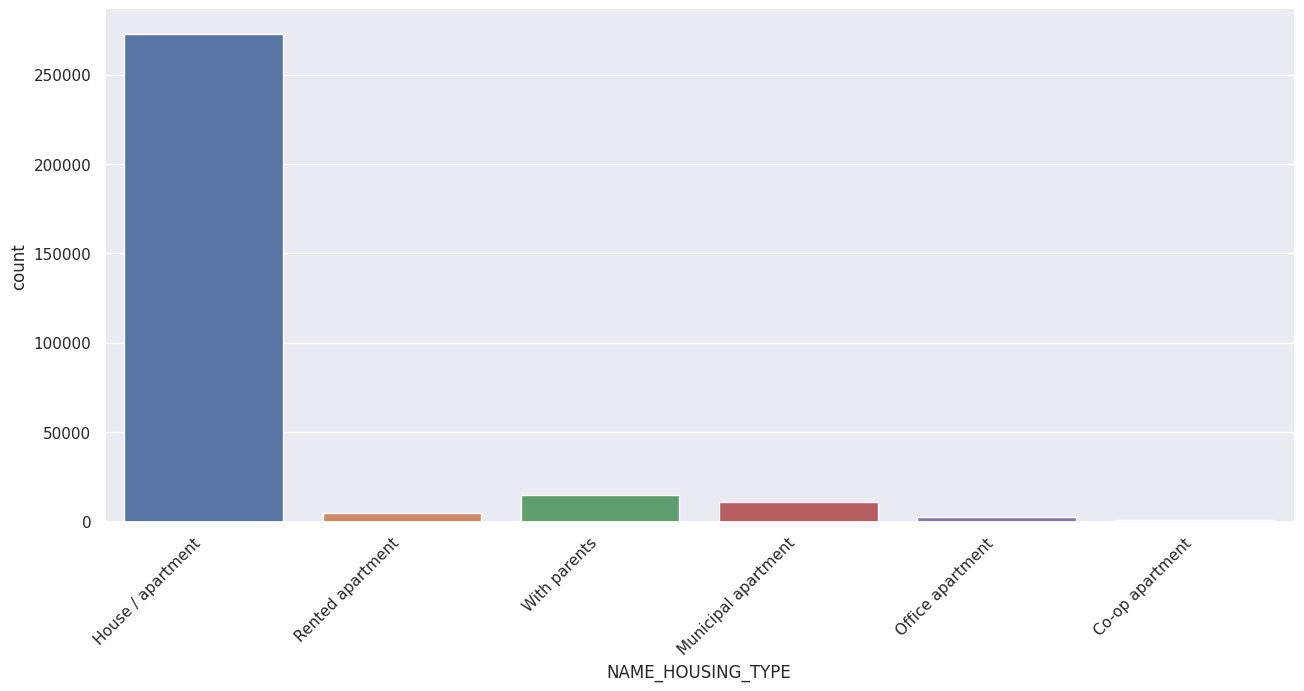

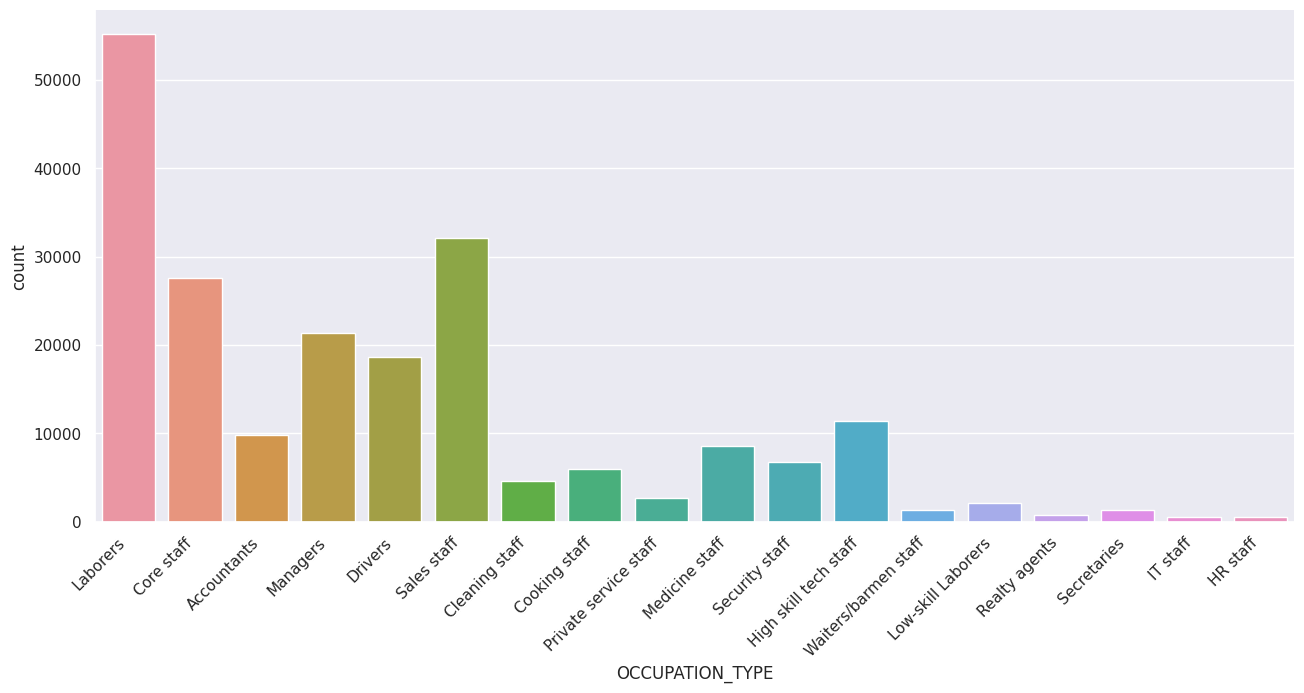

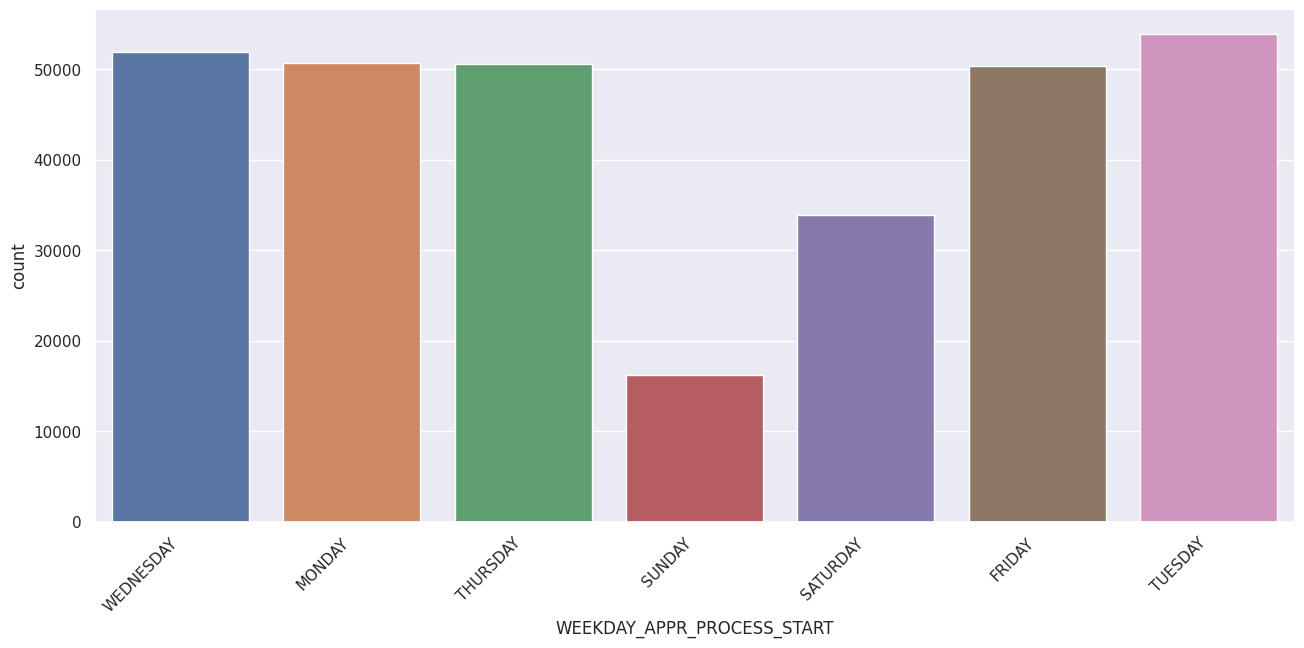

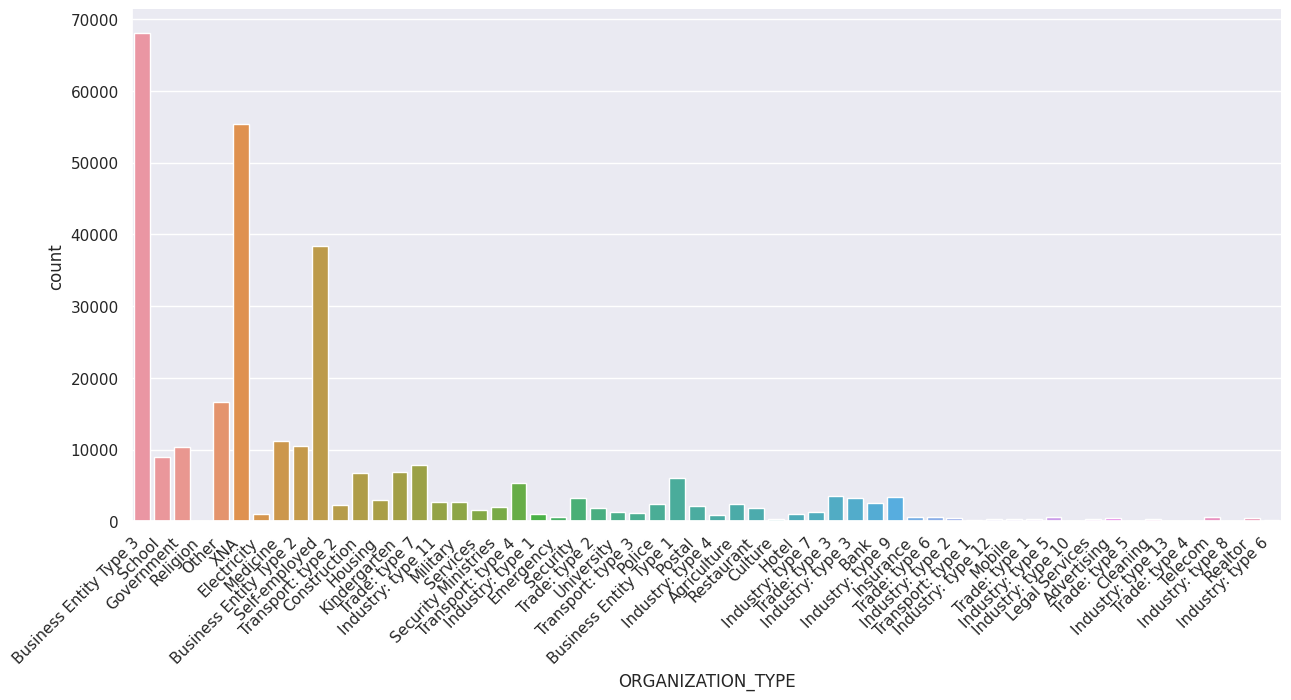

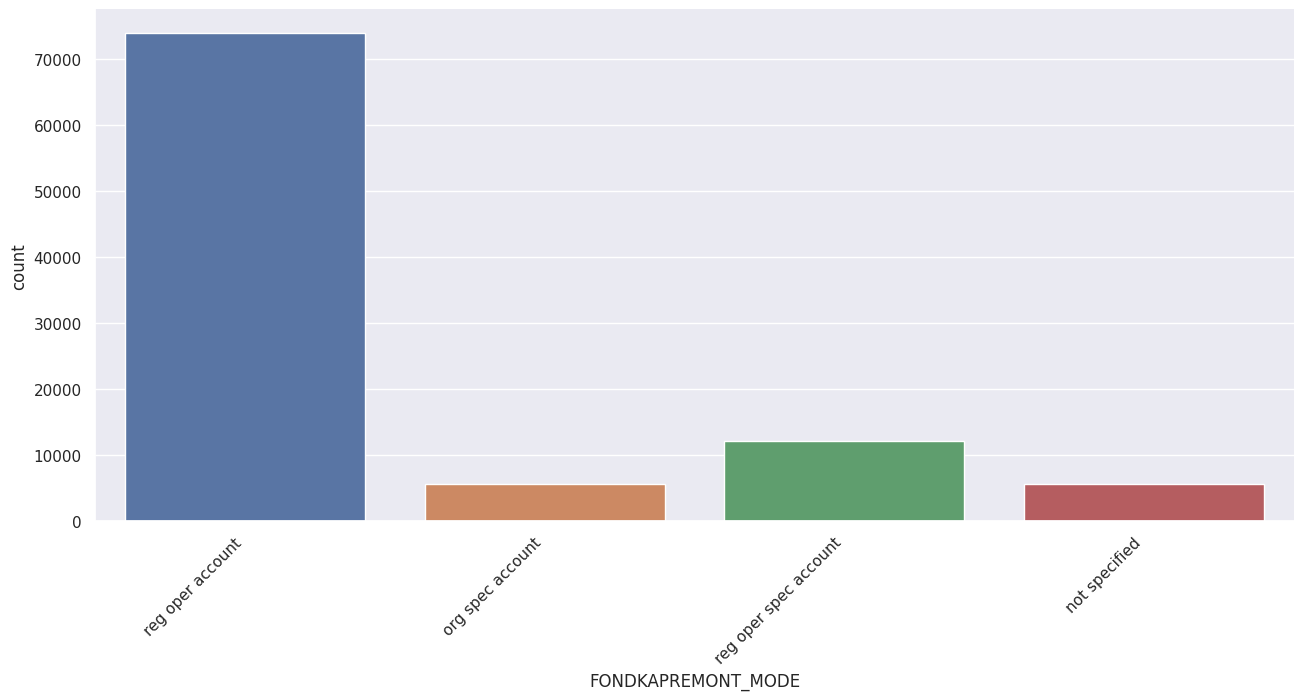

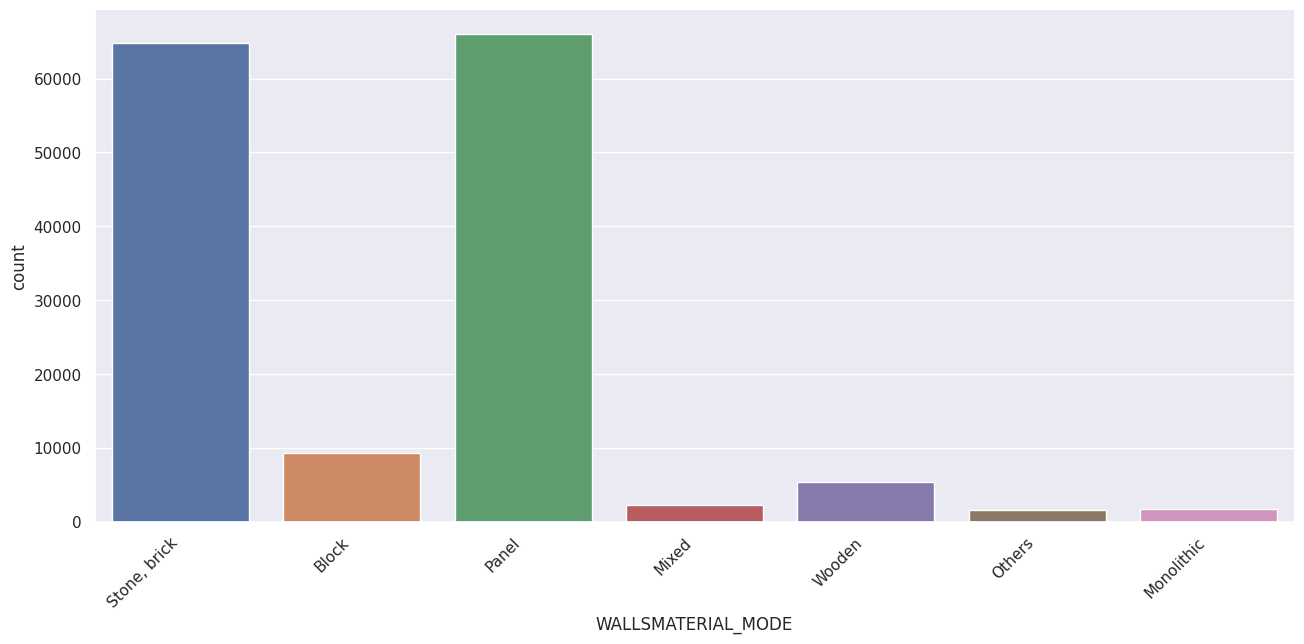

In [ ]:
#@title Categorical Variables
for col in train.columns:
    if train[col].dtype == 'object':
        print("object column %s have %s unique values"%(str(col),train[col].nunique()))
        if train[col].nunique() <= 3:
            print(train[col].value_counts())
            print('-------------')
        else:
            ax = sns.catplot(x=col, kind="count", data=train,height=6, aspect=2.2)
            for axes in ax.axes.flat:
                axes.set_xticklabels(axes.get_xticklabels(),rotation = 45,horizontalalignment = 'right')

<Axes: xlabel='AMT_BALANCE'>

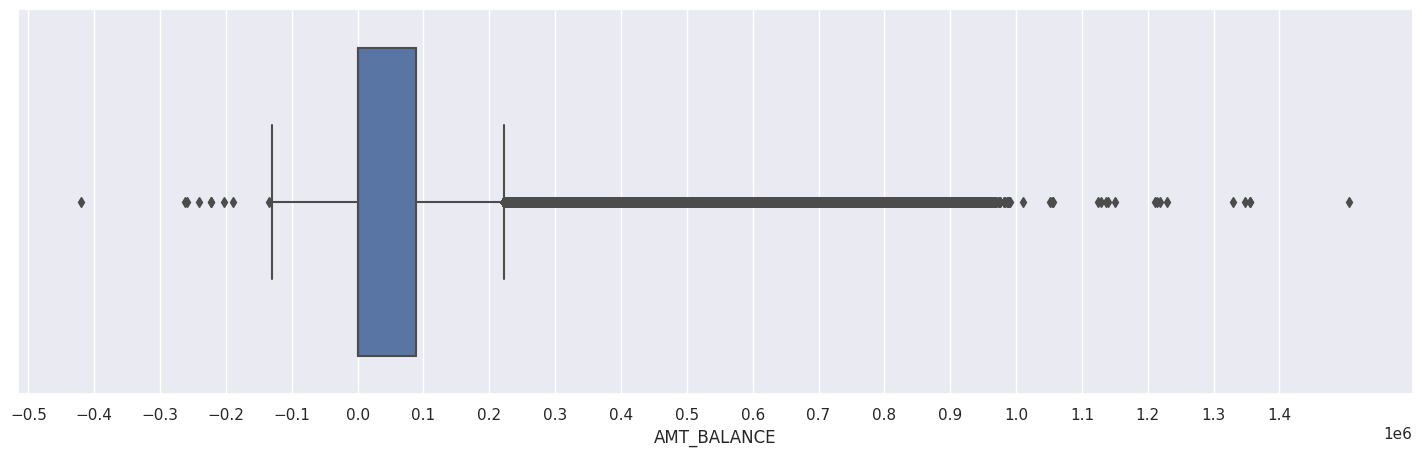

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
ax = sns.boxplot(x=cc['AMT_BALANCE'])
ax.set_xticks([x/10*1e6 for x in range(-5,15,1)])
ax

<Axes: xlabel='CNT_DRAWINGS_CURRENT', ylabel='Count'>

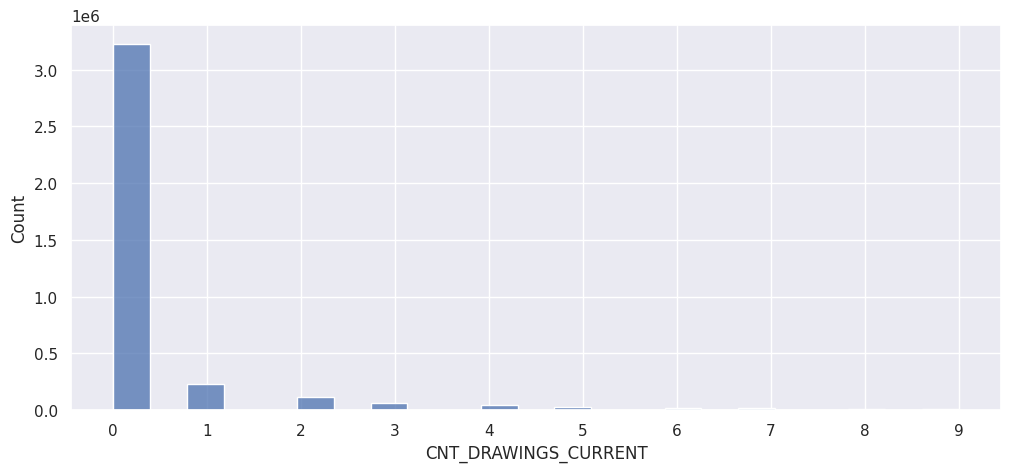

In [ ]:
sns.set(rc={'figure.figsize':(12,5)})
ax = sns.histplot(data=cc[cc.CNT_DRAWINGS_CURRENT < 10], x="CNT_DRAWINGS_CURRENT")
ax.set_xticks(range(0,10,1))
ax

<Axes: xlabel='DAYS_INSTALMENT', ylabel='Count'>

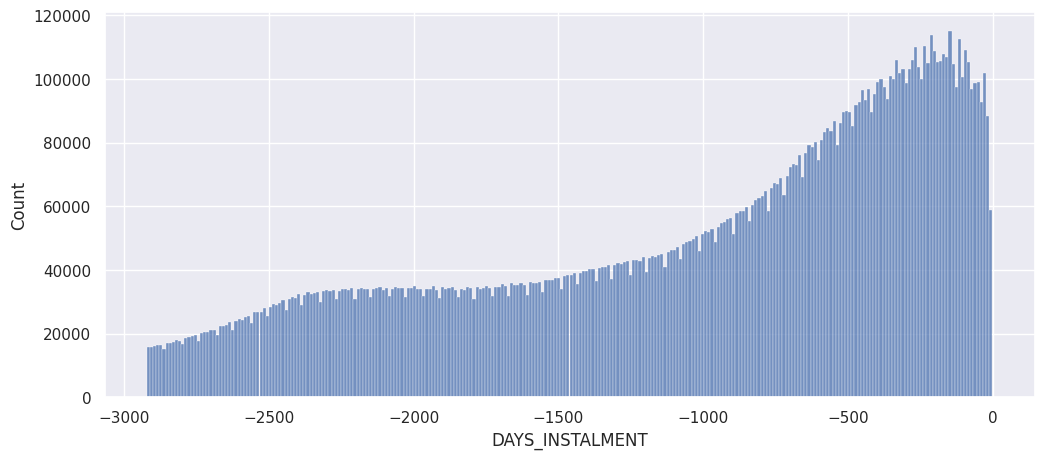

In [ ]:
sns.histplot(data=pmts, x="DAYS_INSTALMENT")

<Axes: xlabel='DAYS_ENTRY_PAYMENT', ylabel='Count'>

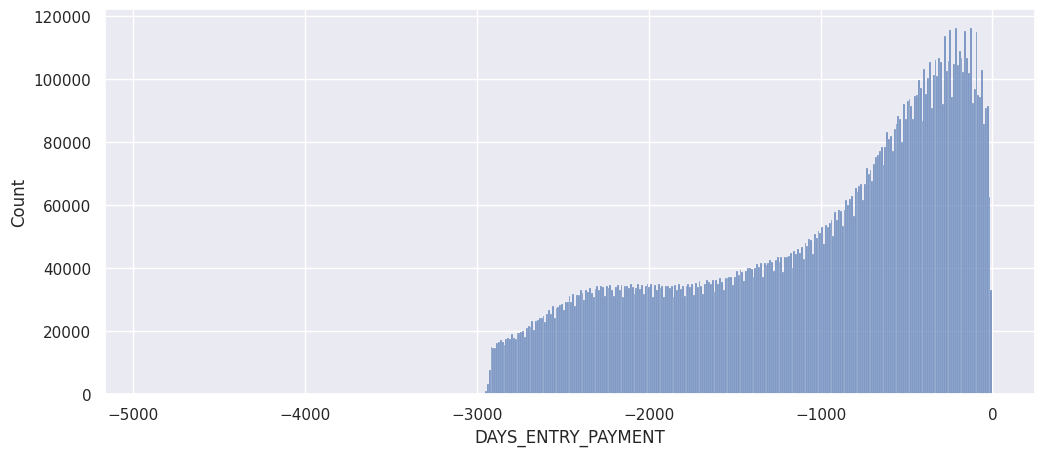

In [ ]:
sns.histplot(data=pmts, x="DAYS_ENTRY_PAYMENT")

# Prepare Data for modeling from the original ADS

In [ ]:
#@title Feature Engineering
# Feature Engineering and extract attributes for use from Credit Card Balance & Installments Payments
cc['AMT_DRAWINGS_PCT'] = [x/y if (y != 0) & pd.notnull(y) else np.nan for x,y in zip(cc.AMT_DRAWINGS_CURRENT,cc.AMT_CREDIT_LIMIT_ACTUAL)]
cc['AMT_DRAWINGS_ATM_PCT'] = [x/y if (y != 0) & pd.notnull(y) else np.nan for x,y in zip(cc.AMT_DRAWINGS_ATM_CURRENT,cc.AMT_CREDIT_LIMIT_ACTUAL)]
cc['AMT_DRAWINGS_OTHER_PCT'] = [x/y if (y != 0) & pd.notnull(y) else np.nan for x,y in zip(cc.AMT_DRAWINGS_OTHER_CURRENT,cc.AMT_CREDIT_LIMIT_ACTUAL)]
cc['AMT_DRAWINGS_POS_PCT'] = [x/y if (y != 0) & pd.notnull(y) else np.nan for x,y in zip(cc.AMT_DRAWINGS_POS_CURRENT,cc.AMT_CREDIT_LIMIT_ACTUAL)]

cc['AMT_PRINCIPAL_RECEIVABLE_PCT'] = [x/y if (y != 0) & pd.notnull(y) else np.nan for x,y in zip(cc.AMT_RECEIVABLE_PRINCIPAL,cc.AMT_RECIVABLE)]

cc_use = cc.groupby(['SK_ID_CURR'],as_index=False).agg({'AMT_BALANCE': np.mean,
                                                        'AMT_DRAWINGS_PCT':np.mean,
                                                        'AMT_DRAWINGS_ATM_PCT':np.mean,
                                                        'AMT_DRAWINGS_OTHER_PCT':np.mean,
                                                        'AMT_DRAWINGS_POS_PCT':np.mean,
                                                        'AMT_PRINCIPAL_RECEIVABLE_PCT':np.mean,
                                                        'CNT_DRAWINGS_ATM_CURRENT':np.mean,
                                                        'CNT_DRAWINGS_CURRENT':np.mean,
                                                        'CNT_DRAWINGS_OTHER_CURRENT':np.mean,
                                                        'CNT_DRAWINGS_POS_CURRENT':np.mean,
                                                        'SK_DPD':np.mean,
                                                        'SK_DPD_DEF':np.mean})
pmts['DAYS_INSTALMENT_DIFF'] = pmts['DAYS_INSTALMENT'] - pmts['DAYS_ENTRY_PAYMENT']
pmts['AMT_PATMENT_PCT'] = [x/y if (y != 0) & pd.notnull(y) else np.nan for x,y in zip(pmts.AMT_PAYMENT,pmts.AMT_INSTALMENT)]
pmts_use = pmts.groupby(['SK_ID_CURR'],as_index=False).agg({'DAYS_INSTALMENT_DIFF':np.mean,
                                                            'AMT_PATMENT_PCT':np.mean})

In [ ]:
#@title Data preparation before applying model

# Remove vars that has too many missing variable
cols_remove = train.columns[train.isnull().sum() > 100000]
train_use = train.drop(cols_remove,axis=1)

# Remove outliers
train_use = train_use[(train_use.CNT_CHILDREN <= 5) & (train_use.CNT_CHILDREN <= 350000)]

# Merge Credit Card Balance & Installment Payments
train_use = train_use.merge(cc_use,on='SK_ID_CURR',how='left')
train_use = train_use.merge(pmts_use,on='SK_ID_CURR',how='left')

# Missing Value Imputation - Assign an extreme value
train_use = train_use.fillna(-999)

# One-hot encoding for categorical variable
cat_cols = [key for key in dict(train_use.dtypes) if dict(train_use.dtypes)[key] in ['object']]
cat_cols_df = pd.get_dummies(train_use[cat_cols],drop_first=True)
train_use = pd.concat([cat_cols_df,train_use[train_use.columns[~train_use.columns.isin(cat_cols)]]], axis = 1)

# print(train_use.shape)
train_use = train_use[train_use.columns[~train_use.columns.isin(cat_cols)]]

# Remove ID column
train_use = train_use.drop(['SK_ID_CURR'],axis=1).reset_index(drop=True)
train_use.replace([np.inf, -np.inf], np.nan, inplace=True)

train_use.shape

(307469, 188)

In [ ]:
#@title Build Decision Tree
x = train_use.drop(['TARGET'],axis=1).copy()
y = train_use['TARGET'].copy()

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=0)
model = DecisionTreeClassifier(criterion='gini')
model = model.fit(x_train,y_train)
y_pred_p = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)

auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score: ", recall_test)

AUC Performance:  0.5367670031029943
F1 Score:  0.14805504933073588
Recall Score:  0.853026311510066


In [ ]:
y_test.value_counts()

0    84914
1     7327
Name: TARGET, dtype: int64

In [ ]:
pd.Series(y_pred).value_counts()

0    83655
1     8586
dtype: int64

In [ ]:
#@title Feature Importance
pd.DataFrame(sorted(zip(x_train.columns,model.feature_importances_),key=lambda x: x[1],reverse=True),columns=['Name','Importance'])[:20]

Name  Importance
0                 EXT_SOURCE_2    0.072903
1                 EXT_SOURCE_3    0.055433
2                   DAYS_BIRTH    0.049553
3         DAYS_INSTALMENT_DIFF    0.047706
4            DAYS_REGISTRATION    0.046466
5              DAYS_ID_PUBLISH    0.045853
6                DAYS_EMPLOYED    0.039611
7                  AMT_ANNUITY    0.039384
8       DAYS_LAST_PHONE_CHANGE    0.035952
9   REGION_POPULATION_RELATIVE    0.034165
10            AMT_INCOME_TOTAL    0.032174
11             AMT_PATMENT_PCT    0.031457
12                  AMT_CREDIT    0.028716
13     HOUR_APPR_PROCESS_START    0.028579
14             AMT_GOODS_PRICE    0.019798
15  AMT_REQ_CREDIT_BUREAU_YEAR    0.016305
16    CNT_DRAWINGS_ATM_CURRENT    0.011336
17    OBS_60_CNT_SOCIAL_CIRCLE    0.010801
18    OBS_30_CNT_SOCIAL_CIRCLE    0.010333
19             CNT_FAM_MEMBERS    0.009824

<Axes: >

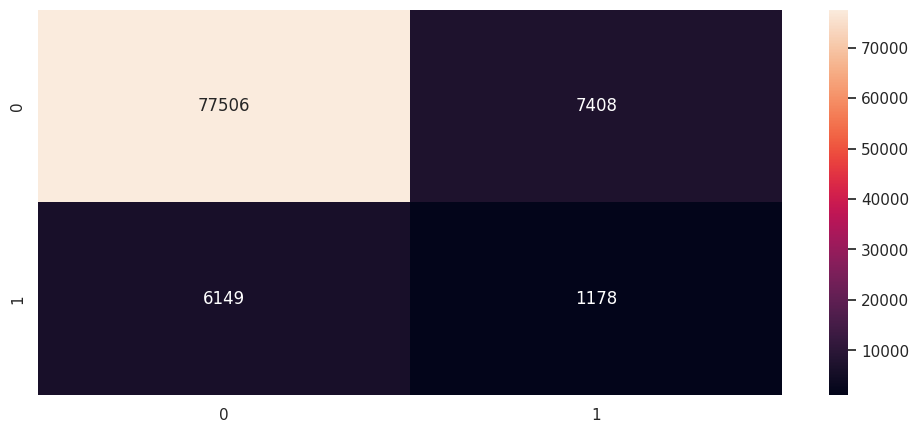

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

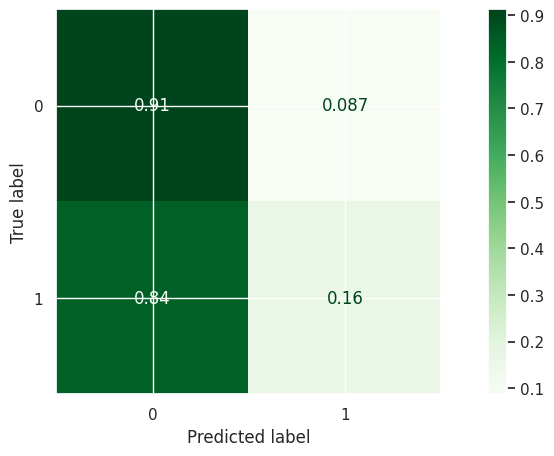

In [ ]:

# assume we have already trained and evaluated our model on test data
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.show()


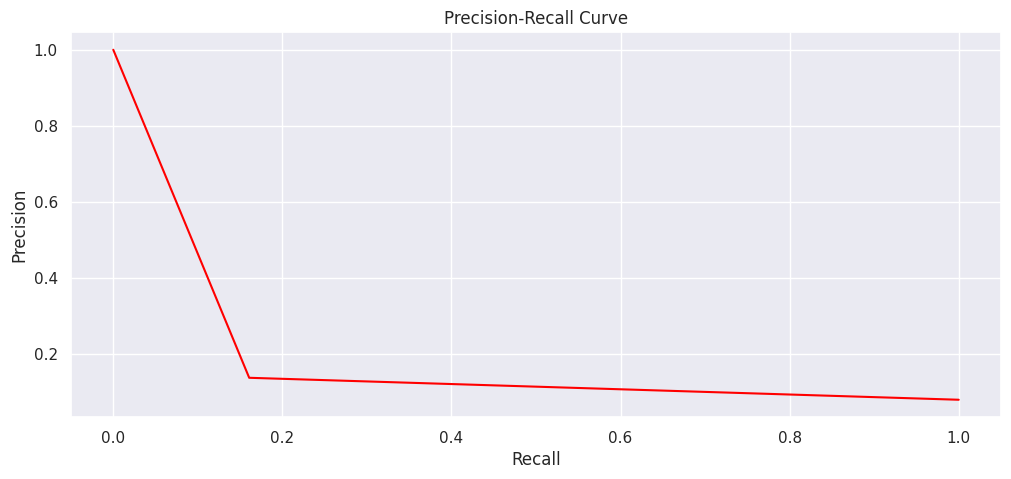

In [ ]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='red')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

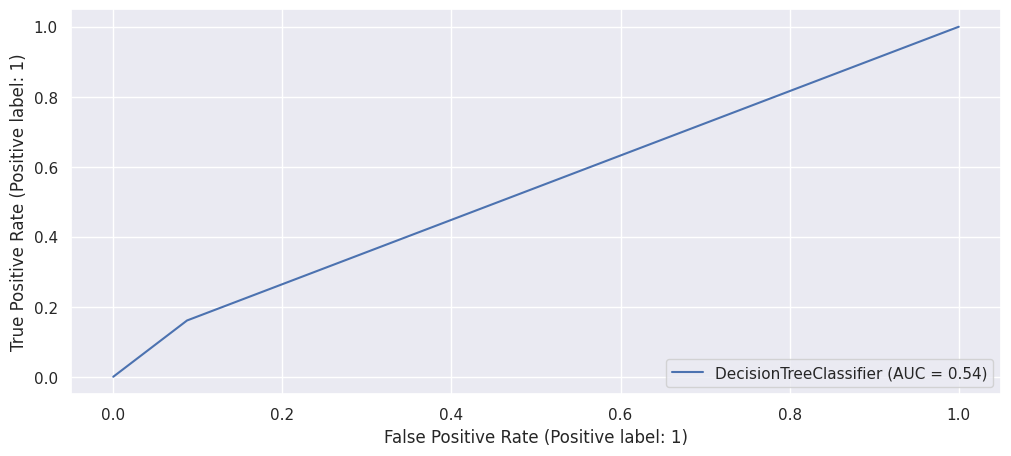

In [ ]:
# ROC Curve
RocCurveDisplay.from_estimator(model, x_test, y_test)

# The original ADS ends here, the rest of the coding was created by us

In [ ]:
#@title Gender Accuracy
male_data = x_test[x_test['CODE_GENDER_M'] == 1]
female_data = x_test[x_test['CODE_GENDER_M'] == 0]

# For Male subpopulation
x_test_male = male_data.copy()
y_test_male = y_test[male_data.index]

y_pred_p_male = model.predict_proba(x_test_male)[:, 1]
y_pred_male = model.predict(x_test_male)

auc_test_male = roc_auc_score(y_test_male, y_pred_p_male)
print("AUC Performance (Male): ", auc_test_male)
f1_test_male = f1_score(y_test_male, y_pred_male)
print("F1 Score (Male): ", f1_test_male)
recall_test_male = recall_score(y_test_male, y_pred_male, average='weighted')
print("Recall Score (Male): ", recall_test_male)

# For Female subpopulation
x_test_female = female_data.copy()
y_test_female = y_test[female_data.index]

y_pred_p_female = model.predict_proba(x_test_female)[:, 1]
y_pred_female = model.predict(x_test_female)

auc_test_female = roc_auc_score(y_test_female, y_pred_p_female)
print("AUC Performance (Female): ", auc_test_female)
f1_test_female = f1_score(y_test_female, y_pred_female)
print("F1 Score (Female): ", f1_test_female)
recall_test_female = recall_score(y_test_female, y_pred_female, average='weighted')
print("Recall Score (Female): ", recall_test_female)

AUC Performance (Male):  0.5361865562490493
F1 Score (Male):  0.16764661540780942
Recall Score (Male):  0.8245686505036383
AUC Performance (Female):  0.5351902467957813
F1 Score (Female):  0.13405172413793104
Recall Score (Female):  0.8677636991936811


In [ ]:
#@title Age Accuracy
ages = [int(-x/365) for x in train.DAYS_BIRTH]
median_age = np.median(ages)
print("Median Age:", median_age)
median_days_birth = np.median(train['DAYS_BIRTH'])
print("Median DAYS_BIRTH:", median_days_birth)


Median Age: 43.0
Median DAYS_BIRTH: -15750.0


In [ ]:
old_data = x_test[x_test['DAYS_BIRTH'] <= -15750]
young_data = x_test[x_test['DAYS_BIRTH'] > -15750.0]

# For Old subpopulation
x_test_old = male_data.copy()
y_test_old = y_test[male_data.index]

y_pred_p_old = model.predict_proba(x_test_old)[:, 1]
y_pred_old = model.predict(x_test_old)

print("For age >= 43: ")
auc_test_old = roc_auc_score(y_test_old, y_pred_p_old)
print("AUC Performance (Old): ", auc_test_old)
f1_test_old = f1_score(y_test_old, y_pred_old)
print("F1 Score (Old): ", f1_test_old)
recall_test_old = recall_score(y_test_old, y_pred_old, average='weighted')
print("Recall Score (Old): ", recall_test_old)

# For Young subpopulation
x_test_young = young_data.copy()
y_test_young = y_test[young_data.index]

y_pred_p_young = model.predict_proba(x_test_young)[:, 1]
y_pred_young = model.predict(x_test_young)

print("For age < 43: ")
auc_test_young = roc_auc_score(y_test_young, y_pred_p_young)
print("AUC Performance (Young): ", auc_test_young)
f1_test_young = f1_score(y_test_young, y_pred_young)
print("F1 Score (Young): ", f1_test_young)
recall_test_young = recall_score(y_test_young, y_pred_young, average='weighted')
print("Recall Score (Young): ", recall_test_young)



For age >= 43: 
AUC Performance (Old):  0.5361865562490493
F1 Score (Old):  0.16764661540780942
Recall Score (Old):  0.8245686505036383
For age < 43: 
AUC Performance (Young):  0.5386009254730956
F1 Score (Young):  0.16875328774329298
Recall Score (Young):  0.8279099146192717


In [ ]:
#@title Has children or not Accuracy
data_no_children = x_test[x_test['CNT_CHILDREN'] == 0]
data_with_children = x_test[x_test['CNT_CHILDREN'] >= 1]

# For subpopulation with no children
x_test_no_children = data_no_children.copy()
y_test_no_children = y_test[data_no_children.index]

y_pred_p_no_children = model.predict_proba(x_test_no_children)[:, 1]
y_pred_no_children = model.predict(x_test_no_children)

auc_test_no_children = roc_auc_score(y_test_no_children, y_pred_p_no_children)
print("AUC Performance (No Children): ", auc_test_no_children)
f1_test_no_children = f1_score(y_test_no_children, y_pred_no_children)
print("F1 Score (No Children): ", f1_test_no_children)
recall_test_no_children = recall_score(y_test_no_children, y_pred_no_children, average='weighted')
print("Recall Score (No Children): ", recall_test_no_children)

# For subpopulation with at least one child
x_test_with_children = data_with_children.copy()
y_test_with_children = y_test[data_with_children.index]

y_pred_p_with_children = model.predict_proba(x_test_with_children)[:, 1]
y_pred_with_children = model.predict(x_test_with_children)

auc_test_with_children = roc_auc_score(y_test_with_children, y_pred_p_with_children)
print("AUC Performance (With Children): ", auc_test_with_children)
f1_test_with_children = f1_score(y_test_with_children, y_pred_with_children)
print("F1 Score (With Children): ", f1_test_with_children)
recall_test_with_children = recall_score(y_test_with_children, y_pred_with_children, average='weighted')
print("Recall Score (With Children): ", recall_test_with_children)

AUC Performance (No Children):  0.5365006333794413
F1 Score (No Children):  0.143609022556391
Recall Score (No Children):  0.8593653537473762
AUC Performance (With Children):  0.5365237406602893
F1 Score (With Children):  0.15702636070548073
Recall Score (With Children):  0.8380633174250428


FNR difference: -0.030445
FPR difference: -0.022589
Demographic parity ratio: 0.675262
Equalized odds ratio: 0.729499
Selection rate difference: 0.025109


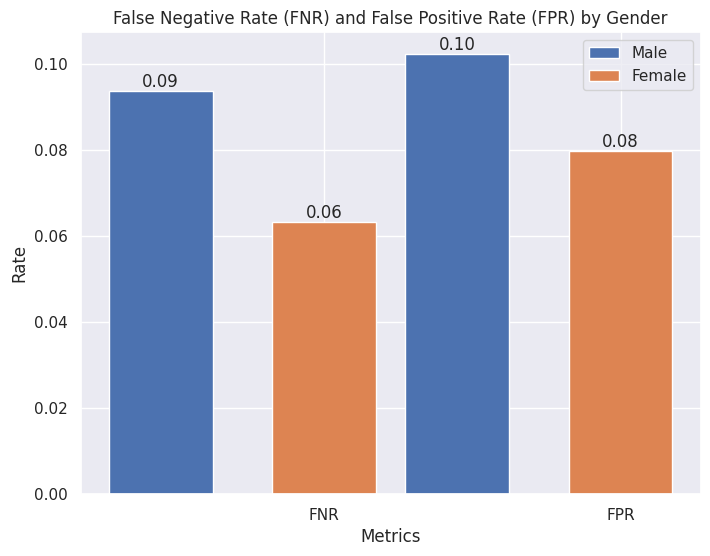

In [ ]:
#@title Gender Fairness
cm_male = confusion_matrix(y_test_male, y_pred_male)
cm_female = confusion_matrix(y_test_female, y_pred_female)

# Extract true positive, false negative, false positive, and true negative values from confusion matrices
tn_male, fp_male, fn_male, tp_male = cm_male.ravel()
tn_female, fp_female, fn_female, tp_female = cm_female.ravel()

# Calculate fairness metrics
fnr_difference = (fn_female / (fn_female + tn_female)) - (fn_male / (fn_male + tn_male))
fpr_difference = (fp_female / (fp_female + tn_female)) - (fp_male / (fp_male + tn_male))
dpratio = (fn_female / (fn_female + tn_female)) / (fn_male / (fn_male + tn_male))
eoratio = ((fn_female / (fn_female + tn_female)) + (fp_female / (fp_female + tn_female))) / \
          ((fn_male / (fn_male + tn_male)) + (fp_male / (fp_male + tn_male)))
selection_difference = ((fn_female + tn_female) / (fn_female + tn_female + fp_female + tp_female)) - \
                       ((fn_male + tn_male) / (fn_male + tn_male + fp_male + tp_male))

# Print fairness metrics
print(f"FNR difference: {fnr_difference:.6f}")
print(f"FPR difference: {fpr_difference:.6f}")
print(f"Demographic parity ratio: {dpratio:.6f}")
print(f"Equalized odds ratio: {eoratio:.6f}")
print(f"Selection rate difference: {selection_difference:.6f}")

# plot fnr and fpr
fnr_male = fn_male / (fn_male + tn_male)
fpr_male = fp_male / (fp_male + tn_male)
fnr_female = fn_female / (fn_female + tn_female)
fpr_female = fp_female / (fp_female + tn_female)
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['FNR', 'FPR']
male_values = [fnr_male, fpr_male]
female_values = [fnr_female, fpr_female]
bar_width = 0.35
bar_spacing = 0.2
index = np.arange(len(metrics))
ax.bar(index, male_values, bar_width, label='Male')
ax.bar(index + bar_width + bar_spacing, female_values, bar_width, label='Female')
ax.set_xlabel('Metrics')
ax.set_ylabel('Rate')
ax.set_title('False Negative Rate (FNR) and False Positive Rate (FPR) by Gender')
ax.set_xticks(index + bar_width + bar_spacing)
ax.set_xticklabels(metrics)
ax.legend()
for i, value in enumerate(male_values):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom')
    ax.text(i + bar_width + bar_spacing, female_values[i], f'{female_values[i]:.2f}', ha='center', va='bottom')
plt.show()

FNR difference: -0.003929
FPR difference: -0.000249
Demographic parity ratio: 0.958086
Equalized odds ratio: 0.978689
Selection rate difference: 0.000046


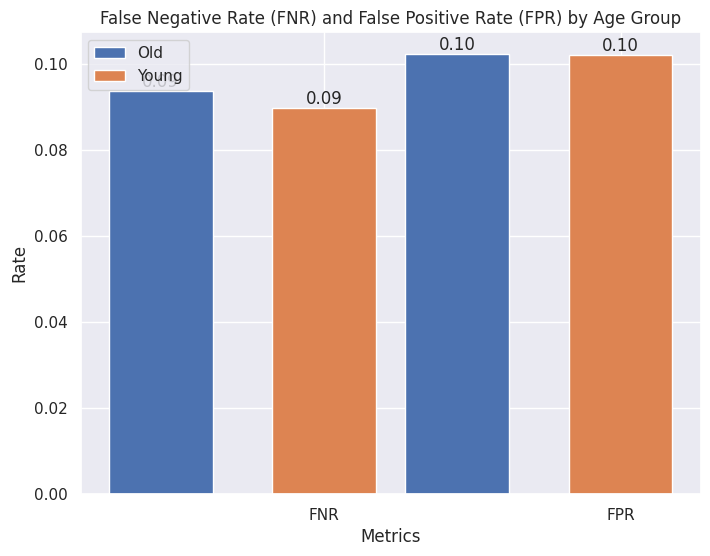

In [ ]:
#@title Age Fairness
# Calculate confusion matrices for old and young subpopulations
cm_old = confusion_matrix(y_test_old, y_pred_old)
cm_young = confusion_matrix(y_test_young, y_pred_young)

# Extract true positive, false negative, false positive, and true negative values from confusion matrices
tn_old, fp_old, fn_old, tp_old = cm_old.ravel()
tn_young, fp_young, fn_young, tp_young = cm_young.ravel()

# Calculate fairness metrics for age groups
fnr_difference = (fn_young / (fn_young + tn_young)) - (fn_old / (fn_old + tn_old))
fpr_difference = (fp_young / (fp_young + tn_young)) - (fp_old / (fp_old + tn_old))
dpratio = (fn_young / (fn_young + tn_young)) / (fn_old / (fn_old + tn_old))
eoratio = ((fn_young / (fn_young + tn_young)) + (fp_young / (fp_young + tn_young))) / \
          ((fn_old / (fn_old + tn_old)) + (fp_old / (fp_old + tn_old)))
selection_difference = ((fn_young + tn_young) / (fn_young + tn_young + fp_young + tp_young)) - \
                       ((fn_old + tn_old) / (fn_old + tn_old + fp_old + tp_old))

# Print fairness metrics for age groups
print(f"FNR difference: {fnr_difference:.6f}")
print(f"FPR difference: {fpr_difference:.6f}")
print(f"Demographic parity ratio: {dpratio:.6f}")
print(f"Equalized odds ratio: {eoratio:.6f}")
print(f"Selection rate difference: {selection_difference:.6f}")

# Plot FNR and FPR for age groups
fnr_old = fn_old / (fn_old + tn_old)
fpr_old = fp_old / (fp_old + tn_old)
fnr_young = fn_young / (fn_young + tn_young)
fpr_young = fp_young / (fp_young + tn_young)
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['FNR', 'FPR']
old_values = [fnr_old, fpr_old]
young_values = [fnr_young, fpr_young]
bar_width = 0.35
bar_spacing = 0.2
index = np.arange(len(metrics))
ax.bar(index, old_values, bar_width, label='Old')
ax.bar(index + bar_width + bar_spacing, young_values, bar_width, label='Young')
ax.set_xlabel('Metrics')
ax.set_ylabel('Rate')
ax.set_title('False Negative Rate (FNR) and False Positive Rate (FPR) by Age Group')
ax.set_xticks(index + bar_width + bar_spacing)
ax.set_xticklabels(metrics)
ax.legend()
for i, value in enumerate(old_values):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom')
    ax.text(i + bar_width + bar_spacing, young_values[i], f'{young_values[i]:.2f}', ha='center', va='bottom')
plt.show()


FNR difference: 0.012310
FPR difference: 0.013598
Demographic parity ratio: 1.176151
Equalized odds ratio: 1.169199
Selection rate difference: -0.014573


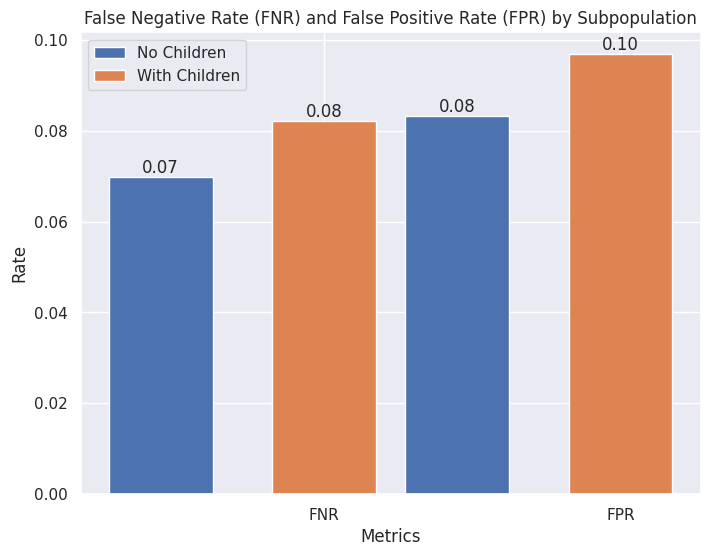

In [ ]:
#@title Children Fairness
# Calculate confusion matrices for subpopulations
cm_no_children = confusion_matrix(y_test_no_children, y_pred_no_children)
cm_with_children = confusion_matrix(y_test_with_children, y_pred_with_children)

# Extract true positive, false negative, false positive, and true negative values from confusion matrices
tn_no_children, fp_no_children, fn_no_children, tp_no_children = cm_no_children.ravel()
tn_with_children, fp_with_children, fn_with_children, tp_with_children = cm_with_children.ravel()

# Calculate fairness metrics for subpopulations
fnr_difference = (fn_with_children / (fn_with_children + tn_with_children)) - (fn_no_children / (fn_no_children + tn_no_children))
fpr_difference = (fp_with_children / (fp_with_children + tn_with_children)) - (fp_no_children / (fp_no_children + tn_no_children))
dpratio = (fn_with_children / (fn_with_children + tn_with_children)) / (fn_no_children / (fn_no_children + tn_no_children))
eoratio = ((fn_with_children / (fn_with_children + tn_with_children)) + (fp_with_children / (fp_with_children + tn_with_children))) / ((fn_no_children / (fn_no_children + tn_no_children)) + (fp_no_children / (fp_no_children + tn_no_children)))
selection_difference = ((fn_with_children + tn_with_children) / (fn_with_children + tn_with_children + fp_with_children + tp_with_children)) - ((fn_no_children + tn_no_children) / (fn_no_children + tn_no_children + fp_no_children + tp_no_children))

# Print fairness metrics for subpopulations
print(f"FNR difference: {fnr_difference:.6f}")
print(f"FPR difference: {fpr_difference:.6f}")
print(f"Demographic parity ratio: {dpratio:.6f}")
print(f"Equalized odds ratio: {eoratio:.6f}")
print(f"Selection rate difference: {selection_difference:.6f}")

# Plot FNR and FPR for subpopulations
fnr_no_children = fn_no_children / (fn_no_children + tn_no_children)
fpr_no_children = fp_no_children / (fp_no_children + tn_no_children)
fnr_with_children = fn_with_children / (fn_with_children + tn_with_children)
fpr_with_children = fp_with_children / (fp_with_children + tn_with_children)
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['FNR', 'FPR']
no_children_values = [fnr_no_children, fpr_no_children]
with_children_values = [fnr_with_children, fpr_with_children]
bar_width = 0.35
bar_spacing = 0.2
index = np.arange(len(metrics))
ax.bar(index, no_children_values, bar_width, label='No Children')
ax.bar(index + bar_width + bar_spacing, with_children_values, bar_width, label='With Children')
ax.set_xlabel('Metrics')
ax.set_ylabel('Rate')
ax.set_title('False Negative Rate (FNR) and False Positive Rate (FPR) by Subpopulation')
ax.set_xticks(index + bar_width + bar_spacing)
ax.set_xticklabels(metrics)
ax.legend()
for i, value in enumerate(no_children_values):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom')
    ax.text(i + bar_width + bar_spacing, with_children_values[i], f'{with_children_values[i]:.2f}', ha='center', va='bottom')
plt.show()


# Testing on Accuracy

In [ ]:
#@title RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV

x = train_use.drop(['TARGET'],axis=1).copy()
y = train_use['TARGET'].copy()

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=0)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, random_state=0)
random_search.fit(x_train, y_train)

# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

y_pred_p = best_model.predict_proba(x_test)[:,1]
y_pred = best_model.predict(x_test)

auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score: ", recall_test)


AUC Performance:  0.6836697474266621
F1 Score:  0.0
Recall Score:  0.920566776162444


In [ ]:
#@title Pruned Model
x = train_use.drop(['TARGET'], axis=1).copy()
y = train_use['TARGET'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Train the pruned model with a fixed ccp_alpha value
ccp_alpha = 0.00005
pruned_model = DecisionTreeClassifier(criterion='gini', ccp_alpha=ccp_alpha)
pruned_model = pruned_model.fit(x_train, y_train)

# Evaluate the pruned model
y_pred_p = pruned_model.predict_proba(x_test)[:, 1]
y_pred = pruned_model.predict(x_test)

auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance with pruning: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score with pruning: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score with pruning: ", recall_test)

AUC Performance with pruning:  0.7051219258956627
F1 Score with pruning:  0.0
Recall Score with pruning:  0.920566776162444


In [ ]:
#@title Under-sampling
from imblearn.under_sampling import RandomUnderSampler
x = train_use.drop(['TARGET'], axis=1).copy()
y = train_use['TARGET'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
# Perform random under-sampling on the training data
rus = RandomUnderSampler(random_state=0)
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

# Train the decision tree classifier on the resampled data
model = DecisionTreeClassifier(criterion='gini')
model = model.fit(x_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_p = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)

# Calculate the evaluation metrics
auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score: ", recall_test)

AUC Performance:  0.5870248111305313
F1 Score:  0.18405821772065706
Recall Score:  0.5842846456564869


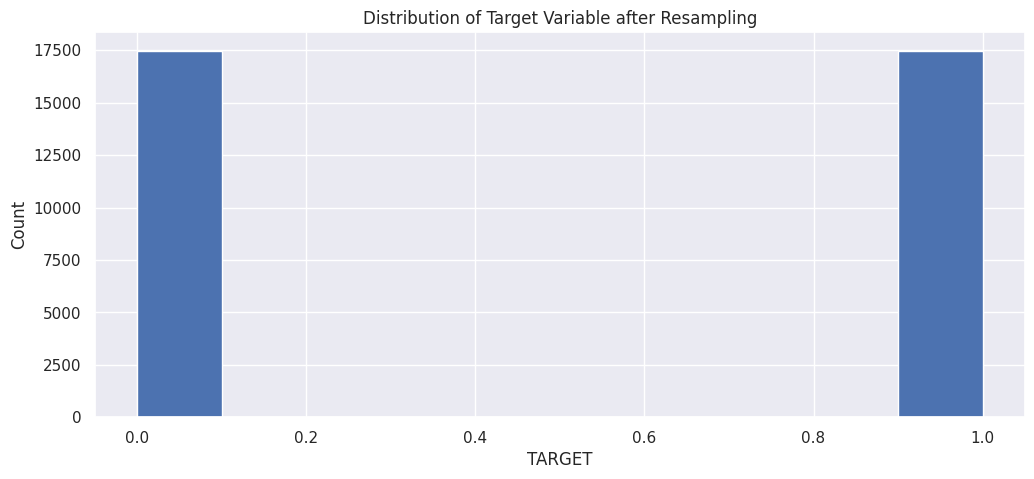

In [ ]:
plt.hist(y_train_resampled)
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.title('Distribution of Target Variable after Resampling')
plt.show()

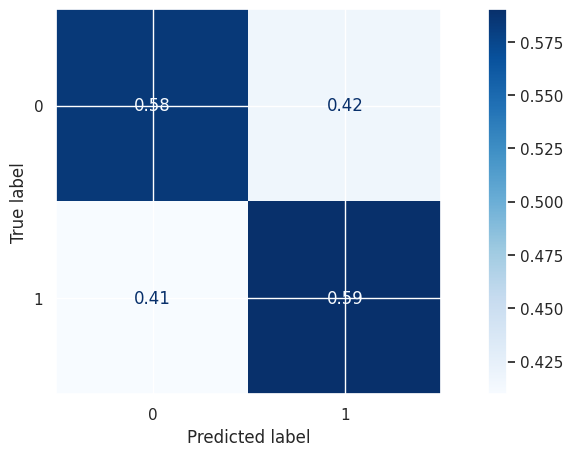

In [ ]:
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Additional Methods

In [ ]:
#@title Cross validation
from sklearn.model_selection import cross_val_score
# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, x, y, cv=5, scoring='roc_auc')
print("AUC Cross-validation scores: ", cv_scores)
print("Average AUC: ", np.mean(cv_scores))


AUC Cross-validation scores:  [0.5424555  0.54031746 0.53670402 0.54437424 0.54102107]
Average AUC:  0.5409744570488726


###Noise injection

In [ ]:
x = train_use.drop(['TARGET'],axis=1).copy()
y = train_use['TARGET'].copy()

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=0)
model = DecisionTreeClassifier(criterion='gini')
model = model.fit(x_train,y_train)
y_pred_p = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)

auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score: ", recall_test)
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.5]  # Define different noise levels

for noise_level in noise_levels:
    X_test_noisy = x_test.copy()
    noise = np.random.normal(0, noise_level, x_test.shape)
    X_test_noisy += noise

    y_pred_p_noisy = model.predict_proba(X_test_noisy)[:, 1]
    y_pred_noisy = model.predict(X_test_noisy)

    auc_test_noisy = roc_auc_score(y_test, y_pred_p_noisy)
    f1_test_noisy = f1_score(y_test, y_pred_noisy)
    recall_test_noisy = recall_score(y_test, y_pred_noisy, average='weighted')

    print(f"Noise level: {noise_level}")
    print(f"AUC Performance: {auc_test_noisy}")
    print(f"F1 Score: {f1_test_noisy}")
    print(f"Recall Score: {recall_test_noisy}")
    print("\n")

AUC Performance:  0.5359547344940291
F1 Score:  0.14673505128846637
Recall Score:  0.852104812393621
Noise level: 0.01
AUC Performance: 0.5346355946180555
F1 Score: 0.1456801470588235
Recall Score: 0.8387701781203586


Noise level: 0.05
AUC Performance: 0.5292554315481627
F1 Score: 0.14141320042852484
Recall Score: 0.8001647857243525


Noise level: 0.1
AUC Performance: 0.530695872871178
F1 Score: 0.1444458757353257
Recall Score: 0.7839897659392244


Noise level: 0.2
AUC Performance: 0.5274473095538511
F1 Score: 0.1427538713236693
Recall Score: 0.7557376871456294


Noise level: 0.5
AUC Performance: 0.5195669145438326
F1 Score: 0.14403618390375827
Recall Score: 0.6019774286922301




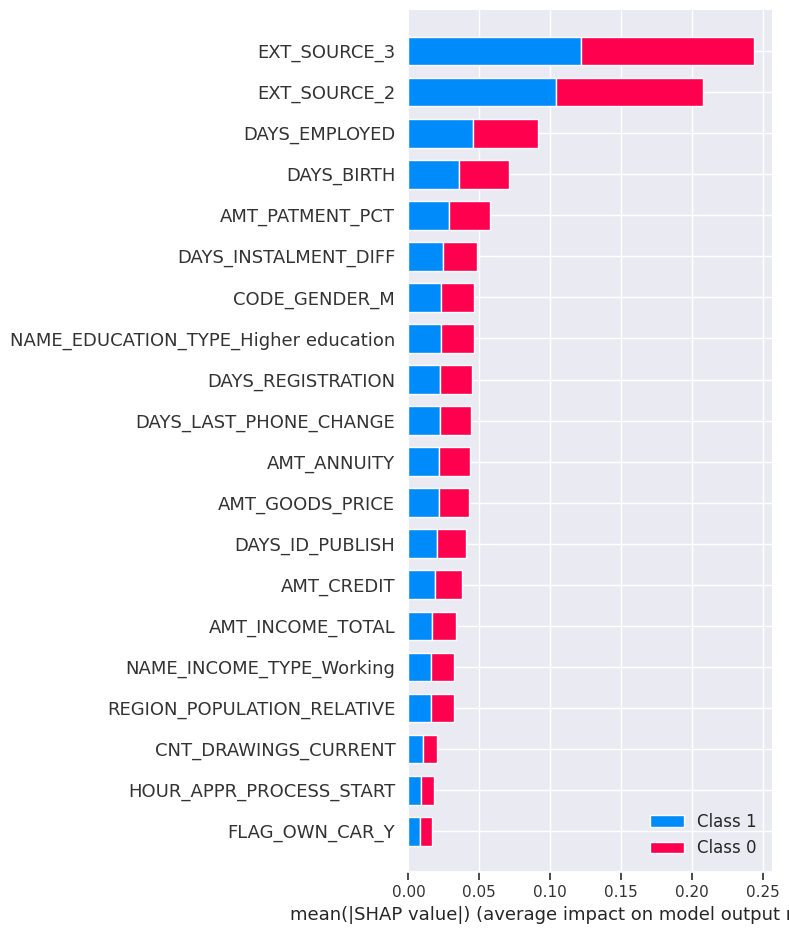

In [ ]:
#@title SHAP

# Convert DataFrame to CSR matrix
x_sparse = sp.csr_matrix(x_test)

# Convert sparse matrix to dense array
x_test_array = x_sparse.toarray()

# Take a random sample of rows
np.random.seed(0)
sample_indices = np.random.choice(x_test_array.shape[0], size=500, replace=False)
x_test_sample = x_test_array[sample_indices, :]
explainer = shap.TreeExplainer(model)
# Calculate SHAP values for the sampled validation set
shap_values = explainer.shap_values(x_test_sample)

# Create summary plot with feature names
shap.summary_plot(shap_values, x_test_sample, feature_names=x_test.columns.values)

In [ ]:
#@title LIME
from lime import lime_tabular
x_test_array = x_test.values

explainer = lime.lime_tabular.LimeTabularExplainer(x_test_array, feature_names=x_test.columns,
                                                   class_names=['Target', 'Non-Target'], verbose=True,
                                                   mode='classification')
y_pred_prob = model.predict_proba(x_test)
selected_instance_index = np.argmax(y_pred_prob[:, 1])
exp = explainer.explain_instance(x_test_array[selected_instance_index], model.predict_proba,
                                  num_features=10, top_labels=1)
print('Explanation for instance with highest predicted probability:')
exp.show_in_notebook(show_table = True, show_all=False)


explainer = lime_tabular.LimeTabularExplainer(x_test.values, feature_names=x_test.columns, class_names=['Target', 'Non-Target'], verbose=True, mode='classification')
instance_id = 0
exp = explainer.explain_instance(x_test.iloc[instance_id].values, model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept -1.1641885646514019
Prediction_local [0.49543311]
Right: 1.0
Explanation for instance with highest predicted probability:


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Intercept 0.2141264864514585
Prediction_local [0.58038034]
Right: 1.0


In [ ]:
#@title Random Forest
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Create a Random Forest Classifier instance and fit it to the training data
model = RandomForestClassifier(criterion='gini', random_state=0)
model = model.fit(x_train, y_train)

# Make predictions and compute performance metrics
y_pred_p = model.predict_proba(x_test)[:, 1]
y_pred = model.predict(x_test)

auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score: ", recall_test)

AUC Performance:  0.7179786456862646
F1 Score:  0.0008185538881309685
Recall Score:  0.9205992996606716


In [ ]:
#subpopulation for age
x_new = train_use.drop(['TARGET'],axis=1).copy()
y_new = train_use['TARGET'].copy()
train_use_filtered = train_use[train_use['DAYS_BIRTH'] <= -15750]
x_new = train_use_filtered.drop(['TARGET'],axis=1)
y_new = train_use_filtered['TARGET']
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=0)
model = RandomForestClassifier(criterion='gini', random_state=0)
model = model.fit(x_train, y_train)
y_pred_p = model.predict_proba(x_test)[:, 1]
y_pred = model.predict(x_test)
auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score: ", recall_test)

x_new = train_use.drop(['TARGET'],axis=1).copy()
y_new = train_use['TARGET'].copy()
train_use_filtered = train_use[train_use['DAYS_BIRTH'] > -15750]
x_new = train_use_filtered.drop(['TARGET'],axis=1)
y_new = train_use_filtered['TARGET']
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=0)
model = RandomForestClassifier(criterion='gini', random_state=0)
model = model.fit(x_train, y_train)
y_pred_p = model.predict_proba(x_test)[:, 1]
y_pred = model.predict(x_test)
auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')

AUC Performance:  0.6927564480846184
F1 Score:  0.0
Recall Score:  0.9368062781824489
AUC Performance:  0.7057390836233132
F1 Score:  0.0021795989537925025


In [ ]:
#subpopulation for gender
x_new = train_use.drop(['TARGET'],axis=1).copy()
y_new = train_use['TARGET'].copy()
train_use_filtered = train_use[train_use['CODE_GENDER_M'] == 0]
x_new = train_use_filtered.drop(['TARGET'],axis=1)
y_new = train_use_filtered['TARGET']
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=0)
model = RandomForestClassifier(criterion='gini', random_state=0)
model = model.fit(x_train, y_train)
y_pred_p = model.predict_proba(x_test)[:, 1]
y_pred = model.predict(x_test)
auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score: ", recall_test)

x_new = train_use.drop(['TARGET'],axis=1).copy()
y_new = train_use['TARGET'].copy()
train_use_filtered = train_use[train_use['CODE_GENDER_M'] == 1]
x_new = train_use_filtered.drop(['TARGET'],axis=1)
y_new = train_use_filtered['TARGET']
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=0)
model = RandomForestClassifier(criterion='gini', random_state=0)
model = model.fit(x_train, y_train)
y_pred_p = model.predict_proba(x_test)[:, 1]
y_pred = model.predict(x_test)
auc_test = roc_auc_score(y_test, y_pred_p)
print("AUC Performance: ", auc_test)
f1_test = f1_score(y_test, y_pred)
print("F1 Score: ", f1_test)
recall_test = recall_score(y_test, y_pred, average='weighted')
print("Recall Score: ", recall_test)

AUC Performance:  0.6975015178750794
F1 Score:  0.000468384074941452
Recall Score:  0.9297205618403069
AUC Performance:  0.7066627125734488
F1 Score:  0.0018501387604070304
Recall Score:  0.8972772277227723


In [ ]:
#@title Logistic Regression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

import re

def clean_feature_names(df):
    return df.rename(columns=lambda x: re.sub(r'[^a-zA-Z0-9]', '_', x))

# Clean the feature names in both training and testing data
x_train = clean_feature_names(x_train)
x_test = clean_feature_names(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_model.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
#@title XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic', random_state=0)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [ ]:
#@title LightGBM

In [ ]:
import lightgbm as lgb
lgbm_model = lgb.LGBMClassifier(objective='binary', random_state=0)
lgbm_model = lgbm_model.fit(x_train, y_train)

In [ ]:
models = [log_reg_model, xgb_model, lgbm_model]
model_names = ['Logistic Regression', 'XGBoost', 'LightGBM']

for name, model in zip(model_names, models):
    y_pred_p = model.predict_proba(x_test)[:, 1]
    y_pred = model.predict(x_test)
    auc_test = roc_auc_score(y_test, y_pred_p)
    f1_test = f1_score(y_test, y_pred)
    recall_test = recall_score(y_test, y_pred, average='weighted')
    print(f"{name}:")
    print("AUC Performance:", auc_test)
    print("F1 Score:", f1_test)
    print("Recall Score:", recall_test)
    print("\n")

Logistic Regression:
AUC Performance: 0.632368857375456
F1 Score: 0.0
Recall Score: 0.9205450938302924


XGBoost:
AUC Performance: 0.7526347485336515
F1 Score: 0.0668439042916825
Recall Score: 0.9200897648551079


LightGBM:
AUC Performance: 0.7592033907770667
F1 Score: 0.036349269063611224
Recall Score: 0.9206751878232022


